Six-Hump Camel synthetic function:

GP EI versus GP dEI (winner)

https://www.sfu.ca/~ssurjano/camel6.html

In [1]:
pip install pyGPGO


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 kB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of arviz to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 

In [2]:
!pip install -q latextable


In [3]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc
rc('text', usetex=False)

from tabulate import tabulate
from texttable import Texttable

import latextable

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [4]:
### Inputs:

obj_func = 'SixHumpCamel'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util = 'EI'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [5]:
### Objective function:

if obj_func == 'SixHumpCamel':

    # True y bounds:
    operator = -1
    y_lb = -1.0316 # targets global minimum
    y_global_orig = y_lb * operator # targets global minimum

# Constraints:
    lb_x1 = -3
    ub_x1 = +3
    lb_x2 = -2
    ub_x2 = +2

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}

# Test data:
    x1_test = np.linspace(lb_x1, ub_x1, n_test)
    x2_test = np.linspace(lb_x2, ub_x2, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training):
        return operator * ((4 - 2.1 * x1_training ** 2 + 1 / 3 * x1_training ** 4) * x1_training ** 2 +
                (x1_training * x2_training) + (-4 + 4 * x2_training ** 2) * x2_training ** 2)


In [6]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [7]:
### Cumulative Regret Calculator:

def min_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [8]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 55
run_num_6 = 660
run_num_7 = 7
run_num_8 = 8
run_num_9 = 99
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 1004
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [9]:
### Surrogate derivatives:

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)

def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE

    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T

        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)

        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.diag(np.dot(dKstar, alpha_Kstar))

        return dm, ds


In [10]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):
    def __init__(self, mode, eps=eps, **params):

        self.params = params
        self.eps = eps

        mode_dict = {
            'EI': self.EI
        }

        self.f = mode_dict[mode]

    def EI(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = df1 + df2
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()

    def d_eval(self, tau, mean, std, ds, dm):

        return self.f(tau, mean, std, ds, dm, **self.params)


In [11]:
n_start_AcqFunc = 20
inverse = -1
n_start = n_start_AcqFunc

maxfunMinimize = 50 * dim # allows for both function and gradient evaluation capping, using the problem's input dimensions


In [12]:
## GPGO_approx: BayesOpt class, acquision function optimised using approximate acquisition function gradients

class GPGO_approx(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t EI exact \t EI approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncApprox = -min(self.f_best)
        self.history.append(self.max_acqfuncApprox)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncExact = -min(self.f_best2)
        self.history.append(self.max_acqfuncExact)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [13]:
## GPGO_exact: BayesOpt class, acquision function optimised using exact acquisition function gradients

class GPGO_exact(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t EI exact \t EI approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncExact = -min(self.f_best)
        self.history.append(self.max_acqfuncExact)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncApprox = -min(self.f_best2)
        self.history.append(self.max_acqfuncApprox)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)

        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [14]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_1 = GPGO_approx(surrogate_approx_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-0.49786797  0.88129797]	 -0.26500829	 -0.26500829	     	     	     	     	    
init	 [-2.99931375 -0.79066971]	 110.13991869	 -0.26500829	     	     	     	     	    
init	 [-2.11946466 -1.63064562]	 26.90935479	 -0.26500829	     	     	     	     	    
init	 [-1.88243873 -0.61775709]	 2.85583631	 -0.26500829	     	     	     	     	    
init	 [-0.61939515  0.15526694]	 1.05405221	 -0.26500829	     	     	     	     	    
1  	 [-1.19209699 -0.31431616]	 2.41860419	 -0.26500829	 27.6 	 1.33780272 	 1.50979901 	 0.886 	 6.369
2  	 [-0.22547579  1.70883971]	 22.24084962	 -0.26500829	 33.6 	 0.70341643 	 0.70463483 	 0.998 	 8.796
3  	 [ 2.48246431 -1.70176508]	 40.65026891	 -0.26500829	 26.0 	 0.67236828 	 0.67237444 	 1.0 	 7.868
4  	 [3. 2.]	 162.9	 -0.26500829	 24.8 	 0.67233605 	 0.67233605 	 1.0 	 5.603
5  	 [-3.  2.]	 150.9	 -0.26500829	 31.5 	 0.64288968 	 0.66838192 	 0.96

In [15]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_2 = GPGO_approx(surrogate_approx_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-0.38403059 -1.89629507]	 38.61280126	 0.01193961	     	     	     	     	    
init	 [ 0.29797487 -0.25871043]	 0.01193961	 0.01193961	     	     	     	     	    
init	 [-0.47779319 -0.67866072]	 0.13814534	 0.01193961	     	     	     	     	    
init	 [-1.7721082   0.47708387]	 0.62614476	 0.01193961	     	     	     	     	    
init	 [-1.20207196 -0.9326909 ]	 3.06938116	 0.01193961	     	     	     	     	    
1  	 [-0.39431495 -0.08552524]	 0.57710144	 0.01193961	 22.2 	 0.9015115 	 0.90656862 	 0.994 	 5.512
2  	 [ 1.85203999 -0.19665791]	 1.95205035	 0.01193961	 30.8 	 0.8038895 	 0.80389974 	 1.0 	 8.09
3  	 [0.73875436 2.        ]	 51.08923695	 0.01193961	 27.8 	 0.8038571 	 0.80384309 	 1.0 	 7.859
4  	 [ 3. -2.]	 150.9	 0.01193961	 29.4 	 0.80352357 	 0.80369058 	 1.0 	 8.581
5  	 [-3.  2.]	 150.9	 0.01193961	 30.0 	 0.80346266 	 0.80363941 	 1.0 	 6.222
6  	 [-3. -2

In [16]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_3 = GPGO_approx(surrogate_approx_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.30478742 0.83259129]	 -0.24319229	 -0.24319229	     	     	     	     	    
init	 [-1.25457157  0.04331042]	 2.33133105	 -0.24319229	     	     	     	     	    
init	 [2.35768173 1.58517236]	 33.54152175	 -0.24319229	     	     	     	     	    
init	 [-2.24648814 -1.17102849]	 14.21410941	 -0.24319229	     	     	     	     	    
init	 [-2.69119678 -0.23676063]	 45.87579772	 -0.24319229	     	     	     	     	    
1  	 [-0.2309166   0.29148206]	 -0.17091165	 -0.24319229	 38.0 	 0.93458395 	 0.93490988 	 1.0 	 7.265
2	 [-0.39661821  0.85835803]	 -0.53762753	 -0.53762753	 45.8 	 0.77440056 	 0.78382157 	 0.988 	 8.662
3  	 [-0.2056751   0.24083065]	 -0.10259844	 -0.53762753	 28.8 	 0.61984004 	 0.62007819 	 1.0 	 5.71
4  	 [-0.53334414  1.38957085]	 7.42443567	 -0.53762753	 33.4 	 0.59611487 	 0.60486605 	 0.986 	 5.913
5  	 [ 0.02178151 -0.23983271]	 -0.22017149	 -0.53762753

In [17]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number =  4

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_4 = GPGO_approx(surrogate_approx_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [2.80217903 0.188929  ]	 63.70212733	 2.31964022	     	     	     	     	    
init	 [2.83610616 0.85926397]	 71.43837111	 2.31964022	     	     	     	     	    
init	 [ 1.18637295 -1.13564202]	 2.54632678	 2.31964022	     	     	     	     	    
init	 [ 2.85764673 -1.97507898]	 113.76785286	 2.31964022	     	     	     	     	    
init	 [-1.48210583 -0.26083387]	 2.31964022	 2.31964022	     	     	     	     	    
1	 [ 0.13819595 -1.09159236]	 0.837873	 0.837873	 23.4 	 2.80166203 	 3.79169214 	 0.739 	 9.75
2	 [ 0.16279961 -1.07402786]	 0.63813103	 0.63813103	 29.0 	 1.23203458 	 1.49081539 	 0.826 	 6.434
3  	 [-3.  2.]	 150.9	 0.63813103	 15.6 	 1.10699102 	 1.14098697 	 0.97 	 6.587
4  	 [-3. -2.]	 162.9	 0.63813103	 24.8 	 1.13115377 	 1.13115377 	 1.0 	 8.12
5	 [-0.26848645 -0.13256574]	 0.24408538	 0.24408538	 23.6 	 1.38422996 	 1.42176206 	 0.974 	 3.914
6	 [ 0.09461061

In [18]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_5 = GPGO_approx(surrogate_approx_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.44135028  1.88662368]	 51.64954283	 -0.80071988	     	     	     	     	    
init	 [-0.09684012 -1.02990919]	 0.39466019	 -0.80071988	     	     	     	     	    
init	 [ 0.18674298 -0.85782306]	 -0.80071988	 -0.80071988	     	     	     	     	    
init	 [ 2.17578226 -1.83559939]	 35.17830829	 -0.80071988	     	     	     	     	    
init	 [-2.3499136   1.06864018]	 12.31874569	 -0.80071988	     	     	     	     	    
1  	 [ 0.37986236 -0.03640806]	 0.51533346	 -0.80071988	 50.2 	 0.49632196 	 0.49692151 	 0.999 	 8.231
2  	 [3. 2.]	 162.9	 -0.80071988	 33.9 	 0.46062865 	 0.46062865 	 1.0 	 12.463
3  	 [-3. -2.]	 162.9	 -0.80071988	 26.4 	 0.46062452 	 0.46062452 	 1.0 	 8.836
4  	 [0.17331313 2.        ]	 48.46489032	 -0.80071988	 33.6 	 0.42650772 	 0.44996623 	 0.948 	 5.071
5	 [-0.06182262 -0.6364794 ]	 -0.90937423	 -0.90937423	 14.8 	 0.35360628 	 0.3588722 	 0.985 	 

In [19]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_6 = GPGO_approx(surrogate_approx_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 1.17097775 -0.59014471]	 0.79681346	 0.47174388	     	     	     	     	    
init	 [-2.77340474  0.79455008]	 55.07980652	 0.47174388	     	     	     	     	    
init	 [2.02046143 1.40318168]	 14.47558754	 0.47174388	     	     	     	     	    
init	 [ 0.97192502 -0.76993343]	 0.47174388	 0.47174388	     	     	     	     	    
init	 [2.62189686 0.20289758]	 36.91862563	 0.47174388	     	     	     	     	    
1  	 [ 0.32966331 -1.25846767]	 3.69344311	 0.47174388	 22.4 	 1.52705765 	 1.57363774 	 0.97 	 5.251
2  	 [-1.89804467 -2.        ]	 54.53683463	 0.47174388	 25.0 	 0.76839644 	 0.76840933 	 1.0 	 5.27
3  	 [ 1.38389492 -2.        ]	 47.53188755	 0.47174388	 21.2 	 0.79690242 	 0.79714789 	 1.0 	 3.818
4	 [ 0.41851066 -0.21666851]	 0.3683285	 0.3683285	 21.2 	 1.82335885 	 1.92423522 	 0.948 	 3.905
5  	 [ 0.47628601 -0.24807498]	 0.45404814	 0.3683285	 22.5 	 1.198603

In [20]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_7 = GPGO_approx(surrogate_approx_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.54215026  1.11967517]	 26.53843864	 -0.46481073	     	     	     	     	    
init	 [-0.36954461  0.89386071]	 -0.46481073	 -0.46481073	     	     	     	     	    
init	 [2.86793707 0.15398348]	 76.66051065	 -0.46481073	     	     	     	     	    
init	 [ 0.00672278 -1.71179547]	 22.61301089	 -0.46481073	     	     	     	     	    
init	 [-1.38936612e+00 -4.69996698e-04]	 2.29458553	 -0.46481073	     	     	     	     	    
1  	 [0.14003009 1.65200772]	 19.18503289	 -0.46481073	 42.8 	 0.62853229 	 0.62855864 	 1.0 	 7.7
2  	 [-2.0069916  -0.34039291]	 4.09787809	 -0.46481073	 3.0 	 0.5869305 	 0.5869305 	 1.0 	 0.0
3  	 [-0.47109136  0.58002622]	 -0.37830203	 -0.46481073	 39.2 	 0.64922776 	 0.65336438 	 0.994 	 6.967
4	 [-0.14196887  0.42856901]	 -0.58081802	 -0.58081802	 51.0 	 0.62712069 	 0.62062543 	 1.01 	 6.253
5  	 [-0.35209166  0.51707389]	 -0.501346	 -0.58081802	

In [21]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_8 = GPGO_approx(surrogate_approx_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [2.24057642 1.87416265]	 48.82879578	 0.03190065	     	     	     	     	    
init	 [2.21516724 0.12342277]	 8.66062355	 0.03190065	     	     	     	     	    
init	 [-1.60363003 -1.95440478]	 48.28332374	 0.03190065	     	     	     	     	    
init	 [-0.41718709 -0.39059456]	 0.2801229	 0.03190065	     	     	     	     	    
init	 [ 0.13604803 -0.08643282]	 0.03190065	 0.03190065	     	     	     	     	    
1  	 [-0.77086886  0.84272184]	 0.23242422	 0.03190065	 37.6 	 0.90225745 	 0.91523883 	 0.986 	 7.524
2  	 [-3.  2.]	 150.9	 0.03190065	 20.1 	 0.78976428 	 0.80818075 	 0.977 	 6.517
3	 [-0.24360329  0.39126551]	 -0.38387908	 -0.38387908	 14.6 	 0.97472493 	 0.97597728 	 0.999 	 2.974
4  	 [-0.24416435  0.38712394]	 -0.37307168	 -0.38387908	 17.7 	 0.68593879 	 0.68663237 	 0.999 	 4.063
5  	 [-0.24497437  0.38151423]	 -0.35837214	 -0.38387908	 25.0 	 0.64816139 	 0.658

In [22]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_9 = GPGO_approx(surrogate_approx_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 1.03367135 -0.0476864 ]	 2.22469625	 2.22469625	     	     	     	     	    
init	 [ 1.95297104 -1.87421445]	 34.84663504	 2.22469625	     	     	     	     	    
init	 [1.84829978 0.26246968]	 2.67497273	 2.22469625	     	     	     	     	    
init	 [-1.21426501 -1.81321712]	 34.68894768	 2.22469625	     	     	     	     	    
init	 [ 2.9437644  -1.97269707]	 133.08463965	 2.22469625	     	     	     	     	    
1  	 [-3.  2.]	 150.9	 2.22469625	 21.0 	 2.35751542 	 2.35844883 	 1.0 	 13.375
2  	 [3. 2.]	 162.9	 2.22469625	 23.6 	 2.32494451 	 2.32494451 	 1.0 	 8.013
3  	 [-0.02159266  1.37606991]	 6.74028294	 2.22469625	 17.7 	 2.05889152 	 2.09468395 	 0.983 	 5.676
4  	 [-3.         -0.79844705]	 110.37098561	 2.22469625	 38.7 	 1.3438288 	 1.34448264 	 1.0 	 6.025
5	 [ 0.8366429  -0.01878197]	 1.86816456	 1.86816456	 16.6 	 1.4171891 	 1.47629969 	 0.96 	 3.601
6  	 [ 0

In [23]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_10 = GPGO_approx(surrogate_approx_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 1.62792386 -1.9169922 ]	 38.25414771	 0.77756875	     	     	     	     	    
init	 [0.80188941 0.99521553]	 2.55265171	 0.77756875	     	     	     	     	    
init	 [-0.00895793 -1.10081342]	 1.03676302	 0.77756875	     	     	     	     	    
init	 [-1.81162281  1.04212285]	 0.77756875	 0.77756875	     	     	     	     	    
init	 [-1.98533498 -1.64664074]	 25.38348144	 0.77756875	     	     	     	     	    
1  	 [3. 2.]	 162.9	 0.77756875	 27.2 	 1.24273737 	 1.24273737 	 1.0 	 9.271
2  	 [-3.  2.]	 150.9	 0.77756875	 30.2 	 1.15340764 	 1.20035475 	 0.961 	 4.957
3  	 [ 3.         -0.56605295]	 106.3308429	 0.77756875	 16.4 	 1.24622213 	 1.24622213 	 1.0 	 4.083
4	 [-0.7532562   0.62545309]	 0.23063112	 0.23063112	 21.9 	 4.02365164 	 4.70260243 	 0.856 	 4.568
5  	 [-0.77425414  0.62943659]	 0.27078525	 0.23063112	 23.1 	 2.24812056 	 2.36216611 	 0.952 	 4.103
6  	 [-

In [24]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_11 = GPGO_approx(surrogate_approx_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-1.91838187 -1.92209903]	 46.39910375	 -0.62546883	     	     	     	     	    
init	 [-0.22068884  0.89973572]	 -0.62546883	 -0.62546883	     	     	     	     	    
init	 [-0.47877837 -0.05829161]	 0.82494702	 -0.62546883	     	     	     	     	    
init	 [-2.92331511 -0.05051357]	 88.99028404	 -0.62546883	     	     	     	     	    
init	 [2.65083991 1.40318036]	 51.4234254	 -0.62546883	     	     	     	     	    
1  	 [ 1.79052491 -2.        ]	 46.64243981	 -0.62546883	 20.4 	 0.49794213 	 0.50121876 	 0.993 	 3.407
2  	 [-0.41855111  2.        ]	 47.80098147	 -0.62546883	 21.4 	 0.47292765 	 0.49903402 	 0.948 	 4.365
3  	 [ 0.09051383 -0.00503656]	 0.0320729	 -0.62546883	 4.6 	 0.58756199 	 0.58780577 	 1.0 	 0.377
4  	 [ 0.08003266 -0.00212966]	 0.02534625	 -0.62546883	 18.6 	 0.45382479 	 0.4792253 	 0.947 	 2.644
5  	 [ 0.07460426 -0.00058538]	 0.02215314	 -0.6254688

In [25]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_12 = GPGO_approx(surrogate_approx_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.07502295  0.96019879]	 2.61858572	 1.99677359	     	     	     	     	    
init	 [-1.42010991  0.13495757]	 1.99677359	 1.99677359	     	     	     	     	    
init	 [-2.91255023  1.67498803]	 101.67816714	 1.99677359	     	     	     	     	    
init	 [ 2.40428912 -1.86631429]	 47.44624884	 1.99677359	     	     	     	     	    
init	 [ 2.74169602 -1.45116271]	 58.32400186	 1.99677359	     	     	     	     	    
1	 [-1.337878    0.82388566]	 0.36879704	 0.36879704	 37.6 	 2.43573176 	 2.60788697 	 0.934 	 9.153
2  	 [1.74301928 2.        ]	 53.60261105	 0.36879704	 25.2 	 0.99580624 	 0.99580622 	 1.0 	 7.501
3  	 [-3. -2.]	 162.9	 0.36879704	 33.4 	 0.99565432 	 0.99565432 	 1.0 	 6.41
4  	 [-0.16291724 -2.        ]	 48.43052941	 0.36879704	 30.4 	 0.98829715 	 0.98829744 	 1.0 	 4.461
5	 [-1.49393438  0.64566136]	 0.23577047	 0.23577047	 30.3 	 0.94410357 	 0.97996765 	 

In [26]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_13 = GPGO_approx(surrogate_approx_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 1.66621446 -1.04983512]	 0.75293092	 0.75293092	     	     	     	     	    
init	 [1.9456712  1.86299679]	 41.05776363	 0.75293092	     	     	     	     	    
init	 [ 2.83560668 -0.18620301]	 69.01345447	 0.75293092	     	     	     	     	    
init	 [0.65425478 1.10210606]	 3.11745217	 0.75293092	     	     	     	     	    
init	 [0.84968007 0.88807292]	 2.00660153	 0.75293092	     	     	     	     	    
1  	 [ 0.69815135 -1.5584218 ]	 14.28054414	 0.75293092	 51.8 	 2.61876409 	 2.68563201 	 0.975 	 11.967
2  	 [-3.  2.]	 150.9	 0.75293092	 27.2 	 1.23023208 	 1.23023218 	 1.0 	 8.045
3  	 [-3. -2.]	 162.9	 0.75293092	 27.2 	 1.23023218 	 1.23023218 	 1.0 	 10.743
4  	 [-1.32681869 -1.1815997 ]	 6.13247436	 0.75293092	 3.0 	 1.23023218 	 1.23023218 	 1.0 	 0.0
5	 [-0.19817028  0.59883805]	 -0.88483668	 -0.88483668	 27.4 	 1.21808871 	 1.22518183 	 0.994 	 5.385
6  	 [-0.2

In [27]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_14 = GPGO_approx(surrogate_approx_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.76629017  1.42598344]	 61.46785297	 1.17102482	     	     	     	     	    
init	 [1.47900185 1.45571157]	 13.82925976	 1.17102482	     	     	     	     	    
init	 [ 0.35990643 -1.67806771]	 20.3334516	 1.17102482	     	     	     	     	    
init	 [-1.61018221 -1.03094392]	 3.99105058	 1.17102482	     	     	     	     	    
init	 [0.69300008 0.42843637]	 1.17102482	 1.17102482	     	     	     	     	    
1  	 [ 3. -2.]	 150.9	 1.17102482	 23.6 	 1.2721368 	 1.33975642 	 0.95 	 6.29
2  	 [-3. -2.]	 162.9	 1.17102482	 22.2 	 1.25192909 	 1.25192909 	 1.0 	 7.482
3	 [-0.49757901  0.41276652]	 0.09589541	 0.09589541	 46.5 	 1.40396444 	 1.42101179 	 0.988 	 8.025
4  	 [-0.45137916  2.        ]	 47.82785981	 0.09589541	 27.4 	 0.7350531 	 0.73956968 	 0.994 	 6.456
5  	 [-0.96266187 -0.30957418]	 2.12007801	 0.09589541	 28.0 	 1.30356353 	 1.33568635 	 0.976 	 4.635
6  	 [-0.

In [28]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_15 = GPGO_approx(surrogate_approx_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 2.09290618 -1.2844163 ]	 6.84252101	 2.11631708	     	     	     	     	    
init	 [-2.67382071 -0.55384622]	 43.69785231	 2.11631708	     	     	     	     	    
init	 [-1.34759443  0.1200009 ]	 2.11631708	 2.11631708	     	     	     	     	    
init	 [-1.16448651 -0.78210256]	 2.35440873	 2.11631708	     	     	     	     	    
init	 [-2.32955234 -1.00040394]	 15.46911925	 2.11631708	     	     	     	     	    
1  	 [-0.31230925  1.23090386]	 3.10796606	 2.11631708	 34.5 	 2.26804703 	 2.26823496 	 1.0 	 6.738
2  	 [3. 2.]	 162.9	 2.11631708	 29.8 	 2.26527327 	 2.26527327 	 1.0 	 10.761
3  	 [-3.  2.]	 150.9	 2.11631708	 24.0 	 2.2379691 	 2.24676743 	 0.996 	 7.597
4	 [-0.27070757 -0.29550408]	 0.04318936	 0.04318936	 20.4 	 2.96292779 	 2.96695934 	 0.999 	 4.58
5  	 [-0.27822716 -0.29112708]	 0.06792524	 0.04318936	 18.6 	 0.94131562 	 0.94568853 	 0.995 	 3.297
6  	 [-

In [29]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_16 = GPGO_approx(surrogate_approx_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-1.66025353  0.09265337]	 1.86327737	 1.86327737	     	     	     	     	    
init	 [ 0.30420874 -1.8175922 ]	 30.24114424	 1.86327737	     	     	     	     	    
init	 [-0.83562699 -1.10767623]	 3.92206128	 1.86327737	     	     	     	     	    
init	 [ 1.13235697 -1.3450743 ]	 6.71216715	 1.86327737	     	     	     	     	    
init	 [-2.5780508   1.76404344]	 53.42443471	 1.86327737	     	     	     	     	    
1  	 [ 3.         -0.04378922]	 108.76097706	 1.86327737	 46.8 	 2.0538856 	 2.05388621 	 1.0 	 10.866
2  	 [-3. -2.]	 162.9	 1.86327737	 18.6 	 2.04789948 	 2.04789948 	 1.0 	 7.36
3  	 [0.53255234 2.        ]	 50.03824176	 1.86327737	 29.6 	 2.04214507 	 2.04216425 	 1.0 	 8.892
4  	 [-0.91745731 -0.01809519]	 2.09313129	 1.86327737	 22.5 	 1.4051753 	 1.48543076 	 0.946 	 6.357
5  	 [-1.03036552 -0.06609219]	 2.32925544	 1.86327737	 28.0 	 0.82039945 	 1.01172657 

In [30]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_17 = GPGO_approx(surrogate_approx_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-1.23200998  0.12234702]	 2.18920665	 1.77227688	     	     	     	     	    
init	 [-1.85087528 -1.72839857]	 29.40606782	 1.77227688	     	     	     	     	    
init	 [1.72191276 0.62533409]	 2.21134014	 1.77227688	     	     	     	     	    
init	 [0.82512538 0.30241158]	 1.77227688	 1.77227688	     	     	     	     	    
init	 [-2.7656225  -0.56874558]	 57.5922316	 1.77227688	     	     	     	     	    
1	 [-0.55712466  1.08599903]	 1.29047129	 1.29047129	 25.5 	 2.25092001 	 2.4395877 	 0.923 	 6.824
2  	 [ 3. -2.]	 150.9	 1.29047129	 20.6 	 1.56975354 	 1.59128838 	 0.986 	 6.477
3  	 [3. 2.]	 162.9	 1.29047129	 20.2 	 1.52413225 	 1.52413225 	 1.0 	 9.124
4  	 [0.92241907 0.18981443]	 2.12460792	 1.29047129	 20.7 	 1.41743895 	 1.41785886 	 1.0 	 4.347
5  	 [-1.56013619  2.        ]	 46.98120007	 1.29047129	 19.8 	 1.41954602 	 1.42428323 	 0.997 	 7.059
6	 [-0.261601

In [31]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_18 = GPGO_approx(surrogate_approx_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.90224545 0.02181349]	 2.06216977	 2.06216977	     	     	     	     	    
init	 [ 2.27160883 -1.2726391 ]	 11.64729291	 2.06216977	     	     	     	     	    
init	 [2.11339841 1.00054514]	 7.79212876	 2.06216977	     	     	     	     	    
init	 [0.99661    1.95158179]	 46.96206223	 2.06216977	     	     	     	     	    
init	 [-1.45818946 -1.8867763 ]	 41.4190528	 2.06216977	     	     	     	     	    
1  	 [-3.  2.]	 150.9	 2.06216977	 27.9 	 2.19985588 	 2.21683068 	 0.992 	 6.273
2	 [ 0.51933718 -0.47021367]	 -0.00043878	 -0.00043878	 29.8 	 1.01892882 	 1.0229041 	 0.996 	 6.772
3	 [ 0.46722715 -0.47742819]	 -0.15039959	 -0.15039959	 42.9 	 0.31814038 	 0.339738 	 0.936 	 5.354
4	 [ 0.44976542 -0.47473192]	 -0.18585102	 -0.18585102	 30.3 	 0.35217427 	 0.36646654 	 0.961 	 4.695
5	 [ 0.44009002 -0.47280303]	 -0.20399717	 -0.20399717	 35.8 	 0.38676251 	 0.39847284 	 

In [32]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_19 = GPGO_approx(surrogate_approx_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.41479839  1.04499887]	 15.89047544	 6.57808885	     	     	     	     	    
init	 [-1.51837216 -1.44747325]	 13.52083951	 6.57808885	     	     	     	     	    
init	 [-1.01132062 -1.66800174]	 23.77215857	 6.57808885	     	     	     	     	    
init	 [1.03186249 1.22637519]	 6.57808885	 6.57808885	     	     	     	     	    
init	 [2.89645149 0.54264294]	 83.31828504	 6.57808885	     	     	     	     	    
1  	 [-0.04594902  2.        ]	 47.91653786	 6.57808885	 19.6 	 5.89231558 	 5.92396596 	 0.995 	 8.819
2  	 [ 1.6626862 -2.       ]	 46.72598899	 6.57808885	 26.6 	 6.28932393 	 6.42134445 	 0.979 	 10.493
3  	 [-3. -2.]	 162.9	 6.57808885	 32.7 	 4.55358523 	 4.55358523 	 1.0 	 9.038
4	 [-0.30754482 -0.24340017]	 0.21175164	 0.21175164	 28.6 	 3.32397078 	 3.32830239 	 0.999 	 4.934
5	 [-0.23874691 -0.2198156 ]	 0.08978274	 0.08978274	 11.7 	 0.14522472 	 0.18454066 

In [33]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_20 = GPGO_approx(surrogate_approx_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.52878481 1.59085491]	 17.29968374	 1.50373928	     	     	     	     	    
init	 [2.34918438 1.26334991]	 20.9158305	 1.50373928	     	     	     	     	    
init	 [-2.78466249  0.76703033]	 57.06253405	 1.50373928	     	     	     	     	    
init	 [-0.72791435  0.07404378]	 1.50373928	 1.50373928	     	     	     	     	    
init	 [ 0.94770879 -1.22459913]	 3.97667377	 1.50373928	     	     	     	     	    
1  	 [-1.16287628 -2.        ]	 52.71897154	 1.50373928	 20.2 	 1.62268979 	 1.62280417 	 1.0 	 9.479
2  	 [ 3. -2.]	 150.9	 1.50373928	 19.5 	 1.48054389 	 1.66805465 	 0.888 	 6.058
3	 [ 0.44491632 -0.32008893]	 0.20184957	 0.20184957	 23.2 	 0.67231212 	 0.70852129 	 0.949 	 2.56
4  	 [ 0.44440555 -0.31347918]	 0.21688155	 0.20184957	 27.9 	 0.13639267 	 0.3543859 	 0.385 	 4.248
5  	 [ 0.44473351 -0.31307702]	 0.21870341	 0.20184957	 26.0 	 0.32500481 	 0.40535397 	 

In [34]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_1 = GPGO_exact(surrogate_exact_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-0.49786797  0.88129797]	 -0.26500829	 -0.26500829	     	     	     	     	    
init	 [-2.99931375 -0.79066971]	 110.13991869	 -0.26500829	     	     	     	     	    
init	 [-2.11946466 -1.63064562]	 26.90935479	 -0.26500829	     	     	     	     	    
init	 [-1.88243873 -0.61775709]	 2.85583631	 -0.26500829	     	     	     	     	    
init	 [-0.61939515  0.15526694]	 1.05405221	 -0.26500829	     	     	     	     	    
1  	 [-1.0222508  -0.56767233]	 1.97381496	 -0.26500829	 13.6 	 1.33780272 	 1.50979901 	 0.886 	 6.937
2  	 [-1.26808267 -0.11971967]	 2.48332081	 -0.26500829	 15.2 	 0.81197673 	 0.84716892 	 0.958 	 4.585
3  	 [-0.46825447  1.65874908]	 19.27896819	 -0.26500829	 8.2 	 0.70603832 	 0.71012232 	 0.994 	 3.082
4  	 [0.57640459 0.14873338]	 1.10858712	 -0.26500829	 9.2 	 0.69733966 	 0.69739484 	 1.0 	 5.123
5  	 [3. 2.]	 162.9	 -0.26500829	 21.5 	 0.67236241 	

In [35]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_2 = GPGO_exact(surrogate_exact_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-0.38403059 -1.89629507]	 38.61280126	 0.01193961	     	     	     	     	    
init	 [ 0.29797487 -0.25871043]	 0.01193961	 0.01193961	     	     	     	     	    
init	 [-0.47779319 -0.67866072]	 0.13814534	 0.01193961	     	     	     	     	    
init	 [-1.7721082   0.47708387]	 0.62614476	 0.01193961	     	     	     	     	    
init	 [-1.20207196 -0.9326909 ]	 3.06938116	 0.01193961	     	     	     	     	    
1  	 [-0.31993922 -0.13822595]	 0.35705703	 0.01193961	 11.9 	 0.9015115 	 0.90656862 	 0.994 	 6.542
2  	 [ 2.04712486 -0.34678071]	 3.2819773	 0.01193961	 12.3 	 0.80387361 	 0.80387501 	 1.0 	 7.704
3  	 [0.87539145 2.        ]	 51.73283838	 0.01193961	 24.8 	 0.80385689 	 0.80385689 	 1.0 	 11.456
4  	 [-3. -2.]	 162.9	 0.01193961	 29.5 	 0.80349602 	 0.80365432 	 1.0 	 4.818
5  	 [3.         1.37226805]	 119.66888349	 0.01193961	 24.4 	 0.7980471 	 0.80357332 	 0

In [36]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_3 = GPGO_exact(surrogate_exact_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.30478742 0.83259129]	 -0.24319229	 -0.24319229	     	     	     	     	    
init	 [-1.25457157  0.04331042]	 2.33133105	 -0.24319229	     	     	     	     	    
init	 [2.35768173 1.58517236]	 33.54152175	 -0.24319229	     	     	     	     	    
init	 [-2.24648814 -1.17102849]	 14.21410941	 -0.24319229	     	     	     	     	    
init	 [-2.69119678 -0.23676063]	 45.87579772	 -0.24319229	     	     	     	     	    
1  	 [-0.24615031  0.33088407]	 -0.23671242	 -0.24319229	 13.8 	 0.93458395 	 0.93490988 	 1.0 	 4.725
2	 [-0.26381503  0.4354689 ]	 -0.46123935	 -0.46123935	 17.9 	 0.78677378 	 0.7886365 	 0.998 	 4.993
3  	 [-0.51799266  1.2341212 ]	 3.47581936	 -0.46123935	 13.2 	 0.65618972 	 0.65793176 	 0.997 	 4.381
4  	 [-0.0673234  -0.21593135]	 -0.14518544	 -0.46123935	 19.6 	 0.76156325 	 0.77107118 	 0.988 	 6.324
5  	 [ 0.05023894 -0.29319294]	 -0.31893774	 -0.461239

In [37]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_4 = GPGO_exact(surrogate_exact_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [2.80217903 0.188929  ]	 63.70212733	 2.31964022	     	     	     	     	    
init	 [2.83610616 0.85926397]	 71.43837111	 2.31964022	     	     	     	     	    
init	 [ 1.18637295 -1.13564202]	 2.54632678	 2.31964022	     	     	     	     	    
init	 [ 2.85764673 -1.97507898]	 113.76785286	 2.31964022	     	     	     	     	    
init	 [-1.48210583 -0.26083387]	 2.31964022	 2.31964022	     	     	     	     	    
1	 [-0.19248638 -0.29673967]	 -0.1187469	 -0.1187469	 18.0 	 2.80166203 	 3.79169214 	 0.739 	 10.087
2	 [ 0.0771446 -0.9683799]	 -0.28444043	 -0.28444043	 22.4 	 1.46184915 	 1.51360221 	 0.966 	 6.699
3  	 [ 0.15454763 -1.42856043]	 8.36963817	 -0.28444043	 15.7 	 1.00807603 	 1.07006129 	 0.942 	 3.93
4  	 [-0.59840288  1.94539575]	 42.16770456	 -0.28444043	 10.4 	 0.63396829 	 0.65186046 	 0.973 	 4.218
5  	 [-3. -2.]	 162.9	 -0.28444043	 5.9 	 0.63397299 	 0.63397

In [38]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_5 = GPGO_exact(surrogate_exact_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.44135028  1.88662368]	 51.64954283	 -0.80071988	     	     	     	     	    
init	 [-0.09684012 -1.02990919]	 0.39466019	 -0.80071988	     	     	     	     	    
init	 [ 0.18674298 -0.85782306]	 -0.80071988	 -0.80071988	     	     	     	     	    
init	 [ 2.17578226 -1.83559939]	 35.17830829	 -0.80071988	     	     	     	     	    
init	 [-2.3499136   1.06864018]	 12.31874569	 -0.80071988	     	     	     	     	    
1  	 [0.30950928 0.00710499]	 0.36620273	 -0.80071988	 18.4 	 0.49632196 	 0.49692151 	 0.999 	 8.867
2  	 [3. 2.]	 162.9	 -0.80071988	 11.8 	 0.46062893 	 0.46062842 	 1.0 	 12.571
3  	 [-3. -2.]	 162.9	 -0.80071988	 11.9 	 0.46062446 	 0.46062446 	 1.0 	 7.884
4  	 [-0.98173165 -0.04678506]	 2.24010759	 -0.80071988	 29.7 	 0.42595391 	 0.42842245 	 0.994 	 3.393
5  	 [0.18064274 2.        ]	 48.48958811	 -0.80071988	 24.7 	 0.44895602 	 0.44895602 	 1.0 	 3.

In [39]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_6 = GPGO_exact(surrogate_exact_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 1.17097775 -0.59014471]	 0.79681346	 0.47174388	     	     	     	     	    
init	 [-2.77340474  0.79455008]	 55.07980652	 0.47174388	     	     	     	     	    
init	 [2.02046143 1.40318168]	 14.47558754	 0.47174388	     	     	     	     	    
init	 [ 0.97192502 -0.76993343]	 0.47174388	 0.47174388	     	     	     	     	    
init	 [2.62189686 0.20289758]	 36.91862563	 0.47174388	     	     	     	     	    
1	 [ 0.15498281 -0.98638317]	 -0.16326725	 -0.16326725	 15.8 	 1.52705765 	 1.57363774 	 0.97 	 4.975
2  	 [ 0.55760851 -1.58159942]	 15.19211248	 -0.16326725	 23.7 	 0.94010946 	 0.9414183 	 0.999 	 4.687
3  	 [ 0.10723463 -0.00315843]	 0.04534129	 -0.16326725	 20.2 	 0.99652885 	 0.9991223 	 0.997 	 5.184
4  	 [0.07471804 0.01947778]	 0.02220413	 -0.16326725	 14.0 	 0.75496259 	 0.75531548 	 1.0 	 4.645
5  	 [0.05002612 0.04208579]	 0.00503039	 -0.16326725	 13.4 	 0.6

In [40]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_7 = GPGO_exact(surrogate_exact_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.54215026  1.11967517]	 26.53843864	 -0.46481073	     	     	     	     	    
init	 [-0.36954461  0.89386071]	 -0.46481073	 -0.46481073	     	     	     	     	    
init	 [2.86793707 0.15398348]	 76.66051065	 -0.46481073	     	     	     	     	    
init	 [ 0.00672278 -1.71179547]	 22.61301089	 -0.46481073	     	     	     	     	    
init	 [-1.38936612e+00 -4.69996698e-04]	 2.29458553	 -0.46481073	     	     	     	     	    
1  	 [0.1310842  1.64834684]	 18.94538119	 -0.46481073	 18.9 	 0.62853229 	 0.62855864 	 1.0 	 5.098
2  	 [-2.0069916  -0.34039291]	 4.09787809	 -0.46481073	 1.0 	 0.5869305 	 0.5869305 	 1.0 	 0.0
3  	 [-0.62752856  0.70661994]	 -0.17355017	 -0.46481073	 15.7 	 0.64924421 	 0.65331769 	 0.994 	 5.63
4	 [-0.29852921  0.52826691]	 -0.62241982	 -0.62241982	 16.6 	 0.62337399 	 0.6290605 	 0.991 	 9.885
5  	 [-3. -2.]	 162.9	 -0.62241982	 9.8 	 0.52500015 	

In [41]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_8 = GPGO_exact(surrogate_exact_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [2.24057642 1.87416265]	 48.82879578	 0.03190065	     	     	     	     	    
init	 [2.21516724 0.12342277]	 8.66062355	 0.03190065	     	     	     	     	    
init	 [-1.60363003 -1.95440478]	 48.28332374	 0.03190065	     	     	     	     	    
init	 [-0.41718709 -0.39059456]	 0.2801229	 0.03190065	     	     	     	     	    
init	 [ 0.13604803 -0.08643282]	 0.03190065	 0.03190065	     	     	     	     	    
1	 [-0.57246742  0.6534526 ]	 -0.25569579	 -0.25569579	 28.7 	 0.90225745 	 0.91523883 	 0.986 	 4.56
2  	 [-1.18831557  1.21804401]	 3.82223307	 -0.25569579	 20.0 	 0.69210184 	 0.69215297 	 1.0 	 4.255
3  	 [0.04982841 0.04620172]	 0.00370053	 -0.25569579	 15.6 	 0.53148748 	 0.61350188 	 0.866 	 2.505
4  	 [ 1.5233709  -1.90834873]	 37.71548824	 -0.25569579	 19.6 	 0.55443413 	 0.61349822 	 0.904 	 3.536
5	 [-0.33912575  0.43440778]	 -0.3269567	 -0.3269567	 21.8 	 0.56

In [42]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number =  9

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_9 = GPGO_exact(surrogate_exact_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 1.03367135 -0.0476864 ]	 2.22469625	 2.22469625	     	     	     	     	    
init	 [ 1.95297104 -1.87421445]	 34.84663504	 2.22469625	     	     	     	     	    
init	 [1.84829978 0.26246968]	 2.67497273	 2.22469625	     	     	     	     	    
init	 [-1.21426501 -1.81321712]	 34.68894768	 2.22469625	     	     	     	     	    
init	 [ 2.9437644  -1.97269707]	 133.08463965	 2.22469625	     	     	     	     	    
1  	 [-1.90915246  2.        ]	 47.00329234	 2.22469625	 18.6 	 2.35751542 	 2.35844883 	 1.0 	 9.301
2  	 [3. 2.]	 162.9	 2.22469625	 6.1 	 2.32491214 	 2.32491214 	 1.0 	 9.804
3  	 [-3.         -0.31745192]	 109.48987585	 2.22469625	 13.2 	 1.8242675 	 1.82443393 	 1.0 	 4.01
4	 [0.78580904 0.09285946]	 1.78651069	 1.78651069	 8.2 	 1.81972309 	 1.82429417 	 0.997 	 1.334
5	 [0.76598728 0.12304471]	 1.72593808	 1.72593808	 9.2 	 1.1382697 	 1.13839628 	 1.0 	 2.16

In [43]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_10 = GPGO_exact(surrogate_exact_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 1.62792386 -1.9169922 ]	 38.25414771	 0.77756875	     	     	     	     	    
init	 [0.80188941 0.99521553]	 2.55265171	 0.77756875	     	     	     	     	    
init	 [-0.00895793 -1.10081342]	 1.03676302	 0.77756875	     	     	     	     	    
init	 [-1.81162281  1.04212285]	 0.77756875	 0.77756875	     	     	     	     	    
init	 [-1.98533498 -1.64664074]	 25.38348144	 0.77756875	     	     	     	     	    
1  	 [3. 2.]	 162.9	 0.77756875	 19.0 	 1.24273737 	 1.24273737 	 1.0 	 8.881
2  	 [-2.52977022  2.        ]	 69.90104467	 0.77756875	 26.1 	 1.15340764 	 1.20035475 	 0.961 	 5.567
3  	 [-0.96096779  0.29985852]	 1.55003079	 0.77756875	 17.5 	 1.24595349 	 1.24609484 	 1.0 	 3.979
4  	 [ 3.         -0.28423181]	 107.75026029	 0.77756875	 17.5 	 1.24610722 	 1.24610722 	 1.0 	 3.085
5	 [-0.348341    0.78170365]	 -0.76792014	 -0.76792014	 14.6 	 1.89338028 	 1.91938404 

In [44]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_11 = GPGO_exact(surrogate_exact_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-1.91838187 -1.92209903]	 46.39910375	 -0.62546883	     	     	     	     	    
init	 [-0.22068884  0.89973572]	 -0.62546883	 -0.62546883	     	     	     	     	    
init	 [-0.47877837 -0.05829161]	 0.82494702	 -0.62546883	     	     	     	     	    
init	 [-2.92331511 -0.05051357]	 88.99028404	 -0.62546883	     	     	     	     	    
init	 [2.65083991 1.40318036]	 51.4234254	 -0.62546883	     	     	     	     	    
1  	 [0.1162043  0.20936558]	 -0.08968929	 -0.62546883	 16.9 	 0.49794213 	 0.50121876 	 0.993 	 2.991
2  	 [-0.26857992  1.50634431]	 11.39164424	 -0.62546883	 16.6 	 0.46476682 	 0.50082822 	 0.928 	 3.065
3  	 [ 1.46188583 -1.88617587]	 35.85055218	 -0.62546883	 10.5 	 0.49924493 	 0.56260801 	 0.887 	 3.114
4  	 [ 0.19155584 -0.03220303]	 0.13365102	 -0.62546883	 8.2 	 0.17563304 	 0.22482717 	 0.781 	 1.699
5  	 [0.05153275 0.10757978]	 -0.02960628	 -0.62546

In [45]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_12 = GPGO_exact(surrogate_exact_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.07502295  0.96019879]	 2.61858572	 1.99677359	     	     	     	     	    
init	 [-1.42010991  0.13495757]	 1.99677359	 1.99677359	     	     	     	     	    
init	 [-2.91255023  1.67498803]	 101.67816714	 1.99677359	     	     	     	     	    
init	 [ 2.40428912 -1.86631429]	 47.44624884	 1.99677359	     	     	     	     	    
init	 [ 2.74169602 -1.45116271]	 58.32400186	 1.99677359	     	     	     	     	    
1	 [-1.15648604  0.74752304]	 0.54016947	 0.54016947	 14.8 	 2.43573176 	 2.60788697 	 0.934 	 10.059
2  	 [1.83110409 2.        ]	 54.03015157	 0.54016947	 19.7 	 1.09688997 	 1.09688994 	 1.0 	 10.363
3  	 [-3. -2.]	 162.9	 0.54016947	 21.3 	 1.09673237 	 1.11583985 	 0.983 	 7.515
4  	 [-0.16342366 -2.        ]	 48.43218496	 0.54016947	 21.8 	 1.08901943 	 1.08901946 	 1.0 	 4.962
5	 [-1.47701775  0.78295093]	 0.08738717	 0.08738717	 14.8 	 1.08769951 	 1.121695

In [46]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_13 = GPGO_exact(surrogate_exact_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 1.66621446 -1.04983512]	 0.75293092	 0.75293092	     	     	     	     	    
init	 [1.9456712  1.86299679]	 41.05776363	 0.75293092	     	     	     	     	    
init	 [ 2.83560668 -0.18620301]	 69.01345447	 0.75293092	     	     	     	     	    
init	 [0.65425478 1.10210606]	 3.11745217	 0.75293092	     	     	     	     	    
init	 [0.84968007 0.88807292]	 2.00660153	 0.75293092	     	     	     	     	    
1  	 [ 0.4943127  -1.24330367]	 3.61710692	 0.75293092	 34.6 	 2.61876409 	 2.68563201 	 0.975 	 5.801
2  	 [-0.83460691  1.3144168 ]	 5.81188295	 0.75293092	 9.9 	 1.59882211 	 1.88870415 	 0.847 	 6.002
3  	 [-3. -2.]	 162.9	 0.75293092	 7.2 	 1.22636521 	 1.31921391 	 0.93 	 11.521
4  	 [ 1.11089436 -2.        ]	 48.1428133	 0.75293092	 19.2 	 1.32020359 	 1.33351248 	 0.99 	 2.824
5  	 [ 2.10322474 -1.94085306]	 43.06366124	 0.75293092	 1.0 	 1.23023218 	 1.23023218 	 

In [47]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_14 = GPGO_exact(surrogate_exact_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.76629017  1.42598344]	 61.46785297	 1.17102482	     	     	     	     	    
init	 [1.47900185 1.45571157]	 13.82925976	 1.17102482	     	     	     	     	    
init	 [ 0.35990643 -1.67806771]	 20.3334516	 1.17102482	     	     	     	     	    
init	 [-1.61018221 -1.03094392]	 3.99105058	 1.17102482	     	     	     	     	    
init	 [0.69300008 0.42843637]	 1.17102482	 1.17102482	     	     	     	     	    
1  	 [-3. -2.]	 162.9	 1.17102482	 21.7 	 1.2721368 	 1.33975642 	 0.95 	 4.364
2  	 [ 2.95556455 -0.45658415]	 94.87662679	 1.17102482	 17.6 	 1.50500008 	 1.51289181 	 0.995 	 4.847
3	 [-0.50274163  0.64593413]	 -0.41510892	 -0.41510892	 12.6 	 1.40576894 	 1.42766043 	 0.985 	 5.838
4  	 [-0.49326459  0.27014806]	 0.44985161	 -0.41510892	 18.4 	 0.57398 	 0.57604194 	 0.996 	 3.24
5  	 [-0.3996789   1.11928318]	 1.40619054	 -0.41510892	 17.8 	 0.50532915 	 0.53218576 

In [48]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_15 = GPGO_exact(surrogate_exact_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 2.09290618 -1.2844163 ]	 6.84252101	 2.11631708	     	     	     	     	    
init	 [-2.67382071 -0.55384622]	 43.69785231	 2.11631708	     	     	     	     	    
init	 [-1.34759443  0.1200009 ]	 2.11631708	 2.11631708	     	     	     	     	    
init	 [-1.16448651 -0.78210256]	 2.35440873	 2.11631708	     	     	     	     	    
init	 [-2.32955234 -1.00040394]	 15.46911925	 2.11631708	     	     	     	     	    
1	 [-0.21638275  1.08971893]	 0.83747544	 0.83747544	 17.5 	 2.26804703 	 2.26823496 	 1.0 	 9.587
2  	 [3. 2.]	 162.9	 0.83747544	 17.0 	 1.28555316 	 1.28555316 	 1.0 	 9.414
3  	 [-1.96941567  2.        ]	 47.43342241	 0.83747544	 23.4 	 1.27190673 	 1.27193904 	 1.0 	 5.032
4  	 [-0.17804804 -2.        ]	 48.48080069	 0.83747544	 29.8 	 1.26194251 	 1.26194251 	 1.0 	 5.981
5  	 [0.70088083 0.45442263]	 1.16076176	 0.83747544	 14.4 	 1.20774376 	 1.21031592 	 0.9

In [49]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_16 = GPGO_exact(surrogate_exact_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-1.66025353  0.09265337]	 1.86327737	 1.86327737	     	     	     	     	    
init	 [ 0.30420874 -1.8175922 ]	 30.24114424	 1.86327737	     	     	     	     	    
init	 [-0.83562699 -1.10767623]	 3.92206128	 1.86327737	     	     	     	     	    
init	 [ 1.13235697 -1.3450743 ]	 6.71216715	 1.86327737	     	     	     	     	    
init	 [-2.5780508   1.76404344]	 53.42443471	 1.86327737	     	     	     	     	    
1  	 [ 3.         -0.03166106]	 108.80101116	 1.86327737	 14.2 	 2.0538856 	 2.05388621 	 1.0 	 9.048
2  	 [-3. -2.]	 162.9	 1.86327737	 13.4 	 2.04789466 	 2.04789466 	 1.0 	 5.661
3  	 [0.53458945 2.        ]	 50.04858829	 1.86327737	 23.2 	 2.0418141 	 2.04181973 	 1.0 	 3.755
4  	 [-1.10134941  0.07301427]	 2.25541266	 1.86327737	 13.2 	 1.40472828 	 1.48589891 	 0.945 	 2.726
5	 [-0.38436994 -0.07390268]	 0.55287769	 0.55287769	 18.7 	 0.87640703 	 1.01571118 	 

In [50]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_17 = GPGO_exact(surrogate_exact_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-1.23200998  0.12234702]	 2.18920665	 1.77227688	     	     	     	     	    
init	 [-1.85087528 -1.72839857]	 29.40606782	 1.77227688	     	     	     	     	    
init	 [1.72191276 0.62533409]	 2.21134014	 1.77227688	     	     	     	     	    
init	 [0.82512538 0.30241158]	 1.77227688	 1.77227688	     	     	     	     	    
init	 [-2.7656225  -0.56874558]	 57.5922316	 1.77227688	     	     	     	     	    
1  	 [-0.94844345  1.77369891]	 27.46470763	 1.77227688	 18.0 	 2.25092001 	 2.4395877 	 0.923 	 7.864
2  	 [ 2.16747806 -2.        ]	 50.67077467	 1.77227688	 14.0 	 1.94727893 	 1.96590533 	 0.991 	 6.843
3  	 [3. 2.]	 162.9	 1.77227688	 9.6 	 1.87718084 	 1.87718084 	 1.0 	 6.975
4  	 [0.97958062 0.2221369 ]	 2.22913798	 1.77227688	 12.8 	 1.62779032 	 1.6289759 	 0.999 	 4.023
5	 [-0.08334248 -0.32165678]	 -0.31654355	 -0.31654355	 18.0 	 1.26415109 	 1.26544315 	 0.9

In [51]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_18 = GPGO_exact(surrogate_exact_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.90224545 0.02181349]	 2.06216977	 2.06216977	     	     	     	     	    
init	 [ 2.27160883 -1.2726391 ]	 11.64729291	 2.06216977	     	     	     	     	    
init	 [2.11339841 1.00054514]	 7.79212876	 2.06216977	     	     	     	     	    
init	 [0.99661    1.95158179]	 46.96206223	 2.06216977	     	     	     	     	    
init	 [-1.45818946 -1.8867763 ]	 41.4190528	 2.06216977	     	     	     	     	    
1  	 [-2.66531515  1.40819569]	 45.98281354	 2.06216977	 20.6 	 2.19985588 	 2.21683068 	 0.992 	 3.668
2  	 [3.        0.6031628]	 109.78368432	 2.06216977	 28.0 	 0.92958603 	 0.93772258 	 0.991 	 3.527
3  	 [1.89592609 0.6375228 ]	 2.96970403	 2.06216977	 1.0 	 2.21916853 	 2.21916853 	 1.0 	 0.0
4  	 [-0.32173714 -1.49268739]	 11.81771426	 2.06216977	 1.0 	 2.21916853 	 2.21916853 	 1.0 	 0.0
5	 [-0.73927187  0.43212922]	 0.68633866	 0.68633866	 15.2 	 2.21014093 	 2.2

In [52]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_19 = GPGO_exact(surrogate_exact_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.41479839  1.04499887]	 15.89047544	 6.57808885	     	     	     	     	    
init	 [-1.51837216 -1.44747325]	 13.52083951	 6.57808885	     	     	     	     	    
init	 [-1.01132062 -1.66800174]	 23.77215857	 6.57808885	     	     	     	     	    
init	 [1.03186249 1.22637519]	 6.57808885	 6.57808885	     	     	     	     	    
init	 [2.89645149 0.54264294]	 83.31828504	 6.57808885	     	     	     	     	    
1  	 [0.10116931 2.        ]	 48.2430599	 6.57808885	 13.2 	 5.89231558 	 5.92396596 	 0.995 	 9.839
2  	 [ 1.4154914  -1.88944898]	 36.29074862	 6.57808885	 13.1 	 6.47993723 	 6.51906566 	 0.994 	 9.968
3  	 [-3. -2.]	 162.9	 6.57808885	 12.1 	 4.56582529 	 4.56582529 	 1.0 	 9.363
4	 [-0.2606682 -0.1399839]	 0.22184399	 0.22184399	 19.0 	 3.79620117 	 3.79895253 	 0.999 	 3.508
5	 [ 0.19813133 -0.17803827]	 -0.00423843	 -0.00423843	 9.7 	 0.1912841 	 0.24125595 	 0.

In [53]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_20 = GPGO_exact(surrogate_exact_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.52878481 1.59085491]	 17.29968374	 1.50373928	     	     	     	     	    
init	 [2.34918438 1.26334991]	 20.9158305	 1.50373928	     	     	     	     	    
init	 [-2.78466249  0.76703033]	 57.06253405	 1.50373928	     	     	     	     	    
init	 [-0.72791435  0.07404378]	 1.50373928	 1.50373928	     	     	     	     	    
init	 [ 0.94770879 -1.22459913]	 3.97667377	 1.50373928	     	     	     	     	    
1  	 [-1.18115566 -2.        ]	 52.76057163	 1.50373928	 29.2 	 1.62268979 	 1.62280417 	 1.0 	 8.689
2  	 [ 2.59213852 -1.65326133]	 47.8496081	 1.50373928	 24.6 	 1.47500799 	 1.66565792 	 0.886 	 2.871
3	 [ 0.22139217 -0.162917  ]	 0.05163369	 0.05163369	 15.2 	 0.4690238 	 0.46905844 	 1.0 	 2.437
4	 [-0.33967677  0.28979802]	 0.02792004	 0.02792004	 13.3 	 0.09328851 	 0.23297858 	 0.4 	 1.911
5	 [ 0.04615981 -0.02633349]	 0.00452595	 0.00452595	 14.0 	 0.32577558 	

In [54]:
### Simple regret minimisation: run number = 1

approx_output_1 = np.append(np.max(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+max_iter)])
exact_output_1 = np.append(np.max(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+max_iter)])

regret_approx_1 = np.log(y_global_orig - approx_output_1)
regret_exact_1 = np.log(y_global_orig - exact_output_1)

simple_regret_approx_1 = min_array(regret_approx_1)
simple_regret_exact_1 = min_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(-0.2658009358573259, -0.2658009358573259)

In [55]:
### Simple regret minimisation: run number = 2

approx_output_2 = np.append(np.max(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+max_iter)])
exact_output_2 = np.append(np.max(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+max_iter)])

regret_approx_2 = np.log(y_global_orig - approx_output_2)
regret_exact_2 = np.log(y_global_orig - exact_output_2)

simple_regret_approx_2 = min_array(regret_approx_2)
simple_regret_exact_2 = min_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(0.033366705791231466, -0.09141497463908152)

In [56]:
### Simple regret minimisation: run number = 3

approx_output_3 = np.append(np.max(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+max_iter)])
exact_output_3 = np.append(np.max(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+max_iter)])

regret_approx_3 = np.log(y_global_orig - approx_output_3)
regret_exact_3 = np.log(y_global_orig - exact_output_3)

simple_regret_approx_3 = min_array(regret_approx_3)
simple_regret_exact_3 = min_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3


(-0.7052754991218033, -1.5614957492289079)

In [57]:
### Simple regret minimisation: run number = 4

approx_output_4 = np.append(np.max(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+max_iter)])
exact_output_4 = np.append(np.max(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+max_iter)])

regret_approx_4 = np.log(y_global_orig - approx_output_4)
regret_exact_4 = np.log(y_global_orig - exact_output_4)

simple_regret_approx_4 = min_array(regret_approx_4)
simple_regret_exact_4 = min_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4


(-5.073457322415554, -1.5236556203622285)

In [58]:
### Simple regret minimisation: run number = 5

approx_output_5 = np.append(np.max(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+max_iter)])
exact_output_5 = np.append(np.max(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+max_iter)])

regret_approx_5 = np.log(y_global_orig - approx_output_5)
regret_exact_5 = np.log(y_global_orig - exact_output_5)

simple_regret_approx_5 = min_array(regret_approx_5)
simple_regret_exact_5 = min_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5


(-2.1018853391540833, -3.892007133182367)

In [59]:
### Simple regret minimisation: run number = 6

approx_output_6 = np.append(np.max(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+max_iter)])
exact_output_6 = np.append(np.max(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+max_iter)])

regret_approx_6 = np.log(y_global_orig - approx_output_6)
regret_exact_6 = np.log(y_global_orig - exact_output_6)

simple_regret_approx_6 = min_array(regret_approx_6)
simple_regret_exact_6 = min_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6


(-0.25847851021237206, -0.5190441652793976)

In [60]:
### Simple regret minimisation: run number = 7

approx_output_7 = np.append(np.max(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+max_iter)])
exact_output_7 = np.append(np.max(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+max_iter)])

regret_approx_7 = np.log(y_global_orig - approx_output_7)
regret_exact_7 = np.log(y_global_orig - exact_output_7)

simple_regret_approx_7 = min_array(regret_approx_7)
simple_regret_exact_7 = min_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7


(-0.7967714768221764, -0.8935996883007996)

In [61]:
### Simple regret minimisation: run number = 8

approx_output_8 = np.append(np.max(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+max_iter)])
exact_output_8 = np.append(np.max(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+max_iter)])

regret_approx_8 = np.log(y_global_orig - approx_output_8)
regret_exact_8 = np.log(y_global_orig - exact_output_8)

simple_regret_approx_8 = min_array(regret_approx_8)
simple_regret_exact_8 = min_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8


(-0.4342953543069644, -1.6667913180754064)

In [62]:
### Simple regret minimisation: run number = 9

approx_output_9 = np.append(np.max(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+max_iter)])
exact_output_9 = np.append(np.max(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+max_iter)])

regret_approx_9 = np.log(y_global_orig - approx_output_9)
regret_exact_9 = np.log(y_global_orig - exact_output_9)

simple_regret_approx_9 = min_array(regret_approx_9)
simple_regret_exact_9 = min_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9


(1.0646295469354679, -0.11828493368480346)

In [63]:
### Simple regret minimisation: run number = 10

approx_output_10 = np.append(np.max(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+max_iter)])
exact_output_10 = np.append(np.max(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+max_iter)])

regret_approx_10 = np.log(y_global_orig - approx_output_10)
regret_exact_10 = np.log(y_global_orig - exact_output_10)

simple_regret_approx_10 = min_array(regret_approx_10)
simple_regret_exact_10 = min_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10


(0.23288088207270655, -1.715961409246572)

In [64]:
### Simple regret minimisation: run number = 11

approx_output_11 = np.append(np.max(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+max_iter)])
exact_output_11 = np.append(np.max(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+max_iter)])

regret_approx_11 = np.log(y_global_orig - approx_output_11)
regret_exact_11 = np.log(y_global_orig - exact_output_11)

simple_regret_approx_11 = min_array(regret_approx_11)
simple_regret_exact_11 = min_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11


(-0.9010790823704407, -1.114233240672245)

In [65]:
### Simple regret minimisation: run number = 12

approx_output_12 = np.append(np.max(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+max_iter)])
exact_output_12 = np.append(np.max(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+max_iter)])

regret_approx_12 = np.log(y_global_orig - approx_output_12)
regret_exact_12 = np.log(y_global_orig - exact_output_12)

simple_regret_approx_12 = min_array(regret_approx_12)
simple_regret_exact_12 = min_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12


(0.23694425972585687, 0.11242396254655553)

In [66]:
### Simple regret minimisation: run number = 13

approx_output_13 = np.append(np.max(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+max_iter)])
exact_output_13 = np.append(np.max(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+max_iter)])

regret_approx_13 = np.log(y_global_orig - approx_output_13)
regret_exact_13 = np.log(y_global_orig - exact_output_13)

simple_regret_approx_13 = min_array(regret_approx_13)
simple_regret_exact_13 = min_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13


(-1.9189340411308784, -3.0989256767941917)

In [67]:
### Simple regret minimisation: run number = 14

approx_output_14 = np.append(np.max(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+max_iter)])
exact_output_14 = np.append(np.max(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+max_iter)])

regret_approx_14 = np.log(y_global_orig - approx_output_14)
regret_exact_14 = np.log(y_global_orig - exact_output_14)

simple_regret_approx_14 = min_array(regret_approx_14)
simple_regret_exact_14 = min_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14


(0.06024231314809976, -0.48371142691937064)

In [68]:
### Simple regret minimisation: run number = 15

approx_output_15 = np.append(np.max(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+max_iter)])
exact_output_15 = np.append(np.max(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+max_iter)])

regret_approx_15 = np.log(y_global_orig - approx_output_15)
regret_exact_15 = np.log(y_global_orig - exact_output_15)

simple_regret_approx_15 = min_array(regret_approx_15)
simple_regret_exact_15 = min_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15


(0.07212470257012685, 0.04583613435076517)

In [69]:
### Simple regret minimisation: run number = 16

approx_output_16 = np.append(np.max(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+max_iter)])
exact_output_16 = np.append(np.max(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+max_iter)])

regret_approx_16 = np.log(y_global_orig - approx_output_16)
regret_exact_16 = np.log(y_global_orig - exact_output_16)

simple_regret_approx_16 = min_array(regret_approx_16)
simple_regret_exact_16 = min_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16


(1.039479277229328, 0.02125213449950844)

In [70]:
### Simple regret minimisation: run number = 17

approx_output_17 = np.append(np.max(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+max_iter)])
exact_output_17 = np.append(np.max(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+max_iter)])

regret_approx_17 = np.log(y_global_orig - approx_output_17)
regret_exact_17 = np.log(y_global_orig - exact_output_17)

simple_regret_approx_17 = min_array(regret_approx_17)
simple_regret_exact_17 = min_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17


(-0.05552461360237015, -3.710479434908689)

In [71]:
### Simple regret minimisation: run number = 18

approx_output_18 = np.append(np.max(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+max_iter)])
exact_output_18 = np.append(np.max(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+max_iter)])

regret_approx_18 = np.log(y_global_orig - approx_output_18)
regret_exact_18 = np.log(y_global_orig - exact_output_18)

simple_regret_approx_18 = min_array(regret_approx_18)
simple_regret_exact_18 = min_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18


(-0.2564534494585051, -0.5314644193063522)

In [72]:
### Simple regret minimisation: run number = 19

approx_output_19 = np.append(np.max(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+max_iter)])
exact_output_19 = np.append(np.max(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+max_iter)])

regret_approx_19 = np.log(y_global_orig - approx_output_19)
regret_exact_19 = np.log(y_global_orig - exact_output_19)

simple_regret_approx_19 = min_array(regret_approx_19)
simple_regret_exact_19 = min_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19


(-0.022992558497444637, -0.02543456866139696)

In [73]:
### Simple regret minimisation: run number = 20

approx_output_20 = np.append(np.max(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+max_iter)])
exact_output_20 = np.append(np.max(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+max_iter)])

regret_approx_20 = np.log(y_global_orig - approx_output_20)
regret_exact_20 = np.log(y_global_orig - exact_output_20)

simple_regret_approx_20 = min_array(regret_approx_20)
simple_regret_exact_20 = min_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20


(0.2098147703936484, -0.0787549835201568)

In [74]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]


In [75]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]


In [76]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]


In [77]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]


In [78]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]


In [79]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]


In [80]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]


In [81]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]


In [82]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]


In [83]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]


In [84]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]


In [85]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]


In [86]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]


In [87]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]


In [88]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]


In [89]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]


In [90]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]


In [91]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]


In [92]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]


In [93]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]


In [94]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]


In [95]:
def extractAcqFuncExact(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-1][::-5]
    return new_array

def extractAcqFuncApprox(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-2][::-5]
    return new_array

def extractTau(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-5][::-5]*-1
    return new_array

def extractNFev(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-3][::-5]
    return new_array

def extractEuclid(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-4][::-5]
    return new_array

In [96]:
exact_1.history


[0.2650082867644827,
 1.337802723187696,
 1.5097990090803877,
 13.6,
 6.9371410506226825,
 0.2650082867644827,
 0.8119767266061962,
 0.8471689169751445,
 15.2,
 4.585295428795504,
 0.2650082867644827,
 0.7060383225758784,
 0.7101223222595778,
 8.2,
 3.0816007060963844,
 0.2650082867644827,
 0.6973396645682188,
 0.6973948434598131,
 9.2,
 5.122674942898536,
 0.2650082867644827,
 0.6723624063241697,
 0.672372642673629,
 21.5,
 5.885347640962862,
 0.2650082867644827,
 0.6718402039315574,
 0.6723721218795542,
 21.3,
 3.9743688219235724,
 0.2650082867644827,
 0.5592210147738894,
 0.6661232280116567,
 18.6,
 2.63249256514127,
 0.2650082867644827,
 0.47205599628571715,
 0.4756414310706339,
 13.2,
 2.305362395230089,
 0.2650082867644827,
 0.4614422415370538,
 0.46390762999203117,
 12.4,
 2.4617825410630045,
 0.2650082867644827,
 0.3502946198152898,
 0.35721865425340865,
 15.8,
 2.7049541962788513,
 0.2650082867644827,
 0.31063730425890596,
 0.3173698910249891,
 11.3,
 2.7702078306470423,
 0.26

In [97]:
exact1_acqFuncExactVector = extractAcqFuncExact(exact_1.history)
exact1_acqFuncApproxVector = extractAcqFuncApprox(exact_1.history)
exact1_tauVector = extractTau(exact_1.history)
approx1_tauVector = extractTau(approx_1.history)
exact1_tau = min(exact1_tauVector)
approx1_tau = min(approx1_tauVector)
exact1_acqFuncExactBest = exact1_acqFuncExactVector[np.argmin(exact1_tauVector)]
exact1_acqFuncApproxBest = exact1_acqFuncApproxVector[np.argmin(exact1_tauVector)]

exact1_acqFuncExactBest, exact1_acqFuncApproxBest, exact1_tau, approx1_tau

exact1_tauVector

array([-0.26500829, -0.26500829, -0.26500829, -0.26500829, -0.26500829,
       -0.26500829, -0.26500829, -0.26500829, -0.26500829, -0.26500829,
       -0.26500829, -0.26500829, -0.26500829, -0.26500829, -0.26500829,
       -0.26500829, -0.26500829, -0.26500829, -0.26500829, -0.26500829])

In [98]:
exact2_acqFuncExactVector = extractAcqFuncExact(exact_2.history)
exact2_acqFuncApproxVector = extractAcqFuncApprox(exact_2.history)
exact2_tauVector = extractTau(exact_2.history)
approx2_tauVector = extractTau(approx_2.history)
exact2_tau = min(exact2_tauVector)
approx2_tau = min(approx2_tauVector)
exact2_acqFuncExactBest = exact2_acqFuncExactVector[np.argmin(exact2_tauVector)]
exact2_acqFuncApproxBest = exact2_acqFuncApproxVector[np.argmin(exact2_tauVector)]

exact2_acqFuncExactBest, exact2_acqFuncApproxBest, exact2_tau, approx2_tau


(0.20741131697578552,
 0.48135000665222916,
 -0.11896108969403411,
 0.00232961771046257)

In [99]:
exact3_acqFuncExactVector = extractAcqFuncExact(exact_3.history)
exact3_acqFuncApproxVector = extractAcqFuncApprox(exact_3.history)
exact3_tauVector = extractTau(exact_3.history)
approx3_tauVector = extractTau(approx_3.history)
exact3_tau = min(exact3_tauVector)
approx3_tau = min(approx3_tauVector)
exact3_acqFuncExactBest = exact3_acqFuncExactVector[np.argmin(exact3_tauVector)]
exact3_acqFuncApproxBest = exact3_acqFuncApproxVector[np.argmin(exact3_tauVector)]

exact3_acqFuncExactBest, exact3_acqFuncApproxBest, exact3_tau, approx3_tau


(0.4590511731670196,
 0.5436492228636884,
 -0.8217780047177372,
 -0.5376275334725007)

In [100]:
exact4_acqFuncExactVector = extractAcqFuncExact(exact_4.history)
exact4_acqFuncApproxVector = extractAcqFuncApprox(exact_4.history)
exact4_tauVector = extractTau(exact_4.history)
approx4_tauVector = extractTau(approx_4.history)
exact4_tau = min(exact4_tauVector)
approx4_tau = min(approx4_tauVector)
exact4_acqFuncExactBest = exact4_acqFuncExactVector[np.argmin(exact4_tauVector)]
exact4_acqFuncApproxBest = exact4_acqFuncApproxVector[np.argmin(exact4_tauVector)]

exact4_acqFuncExactBest, exact4_acqFuncApproxBest, exact4_tau, approx4_tau


(0.30331201384545076,
 0.36160833649107627,
 -0.8136861810695815,
 -1.0253392627072793)

In [101]:
exact5_acqFuncExactVector = extractAcqFuncExact(exact_5.history)
exact5_acqFuncApproxVector = extractAcqFuncApprox(exact_5.history)
exact5_tauVector = extractTau(exact_5.history)
approx5_tauVector = extractTau(approx_5.history)
exact5_tau = min(exact5_tauVector)
approx5_tau = min(approx5_tauVector)
exact5_acqFuncExactBest = exact5_acqFuncExactVector[np.argmin(exact5_tauVector)]
exact5_acqFuncApproxBest = exact5_acqFuncApproxVector[np.argmin(exact5_tauVector)]

exact5_acqFuncExactBest, exact5_acqFuncApproxBest, exact5_tau, approx5_tau


(0.36782371837897454,
 0.40099955305398766,
 -1.0111956493391665,
 -0.9093742261466655)

In [102]:
exact6_acqFuncExactVector = extractAcqFuncExact(exact_6.history)
exact6_acqFuncApproxVector = extractAcqFuncApprox(exact_6.history)
exact6_tauVector = extractTau(exact_6.history)
approx6_tauVector = extractTau(approx_6.history)
exact6_tau = min(exact6_tauVector)
approx6_tau = min(approx6_tauVector)
exact6_acqFuncExactBest = exact6_acqFuncExactVector[np.argmin(exact6_tauVector)]
exact6_acqFuncApproxBest = exact6_acqFuncApproxVector[np.argmin(exact6_tauVector)]

exact6_acqFuncExactBest, exact6_acqFuncApproxBest, exact6_tau, approx6_tau


(0.4761161023446776,
 0.5508954821113057,
 -0.43651091697845873,
 -0.259374374164425)

In [103]:
exact7_acqFuncExactVector = extractAcqFuncExact(exact_7.history)
exact7_acqFuncApproxVector = extractAcqFuncApprox(exact_7.history)
exact7_tauVector = extractTau(exact_7.history)
approx7_tauVector = extractTau(approx_7.history)
exact7_tau = min(exact7_tauVector)
approx7_tau = min(approx7_tauVector)
exact7_acqFuncExactBest = exact7_acqFuncExactVector[np.argmin(exact7_tauVector)]
exact7_acqFuncApproxBest = exact7_acqFuncApproxVector[np.argmin(exact7_tauVector)]

exact7_acqFuncExactBest, exact7_acqFuncApproxBest, exact7_tau, approx7_tau


(0.6233739906842195,
 0.6290604952211579,
 -0.6224198225575582,
 -0.5808180226262771)

In [104]:
exact8_acqFuncExactVector = extractAcqFuncExact(exact_8.history)
exact8_acqFuncApproxVector = extractAcqFuncApprox(exact_8.history)
exact8_tauVector = extractTau(exact_8.history)
approx8_tauVector = extractTau(approx_8.history)
exact8_tau = min(exact8_tauVector)
approx8_tau = min(approx8_tauVector)
exact8_acqFuncExactBest = exact8_acqFuncExactVector[np.argmin(exact8_tauVector)]
exact8_acqFuncApproxBest = exact8_acqFuncApproxVector[np.argmin(exact8_tauVector)]

exact8_acqFuncExactBest, exact8_acqFuncApproxBest, exact8_tau, approx8_tau


(0.6024265777679326,
 0.6086426276424637,
 -0.8427479393050974,
 -0.38387907993258125)

In [105]:
exact9_acqFuncExactVector = extractAcqFuncExact(exact_9.history)
exact9_acqFuncApproxVector = extractAcqFuncApprox(exact_9.history)
exact9_tauVector = extractTau(exact_9.history)
approx9_tauVector = extractTau(approx_9.history)
exact9_tau = min(exact9_tauVector)
approx9_tau = min(approx9_tauVector)
exact9_acqFuncExactBest = exact9_acqFuncExactVector[np.argmin(exact9_tauVector)]
exact9_acqFuncApproxBest = exact9_acqFuncApproxVector[np.argmin(exact9_tauVector)]

exact9_acqFuncExactBest, exact9_acqFuncApproxBest, exact9_tau, approx9_tau


(0.40758874452982996,
 0.6284063755586834,
 -0.14315713075437642,
 1.868164558392703)

In [106]:
exact10_acqFuncExactVector = extractAcqFuncExact(exact_10.history)
exact10_acqFuncApproxVector = extractAcqFuncApprox(exact_10.history)
exact10_tauVector = extractTau(exact_10.history)
approx10_tauVector = extractTau(approx_10.history)
exact10_tau = min(exact10_tauVector)
approx10_tau = min(approx10_tauVector)
exact10_acqFuncExactBest = exact10_acqFuncExactVector[np.argmin(exact10_tauVector)]
exact10_acqFuncApproxBest = exact10_acqFuncApproxVector[np.argmin(exact10_tauVector)]

exact10_acqFuncExactBest, exact10_acqFuncApproxBest, exact10_tau, approx10_tau


(0.7362749203953383,
 0.7402546400356248,
 -0.8518092149277464,
 0.23063111601765074)

In [107]:
exact11_acqFuncExactVector = extractAcqFuncExact(exact_11.history)
exact11_acqFuncApproxVector = extractAcqFuncApprox(exact_11.history)
exact11_tauVector = extractTau(exact_11.history)
approx11_tauVector = extractTau(approx_11.history)
exact11_tau = min(exact11_tauVector)
approx11_tau = min(approx11_tauVector)
exact11_acqFuncExactBest = exact11_acqFuncExactVector[np.argmin(exact11_tauVector)]
exact11_acqFuncApproxBest = exact11_acqFuncApproxVector[np.argmin(exact11_tauVector)]

exact11_acqFuncExactBest, exact11_acqFuncApproxBest, exact11_tau, approx11_tau


(0.051906567068633024,
 0.3494307263186036,
 -0.7034331925830066,
 -0.6254688257880329)

In [108]:
exact12_acqFuncExactVector = extractAcqFuncExact(exact_12.history)
exact12_acqFuncApproxVector = extractAcqFuncApprox(exact_12.history)
exact12_tauVector = extractTau(exact_12.history)
approx12_tauVector = extractTau(approx_12.history)
exact12_tau = min(exact12_tauVector)
approx12_tau = min(approx12_tauVector)
exact12_acqFuncExactBest = exact12_acqFuncExactVector[np.argmin(exact12_tauVector)]
exact12_acqFuncApproxBest = exact12_acqFuncApproxVector[np.argmin(exact12_tauVector)]

exact12_acqFuncExactBest, exact12_acqFuncApproxBest, exact12_tau, approx12_tau


(1.087699506298879,
 1.121695197774255,
 0.08738716874312946,
 0.23577047222883796)

In [109]:
exact13_acqFuncExactVector = extractAcqFuncExact(exact_13.history)
exact13_acqFuncApproxVector = extractAcqFuncApprox(exact_13.history)
exact13_tauVector = extractTau(exact_13.history)
approx13_tauVector = extractTau(approx_13.history)
exact13_tau = min(exact13_tauVector)
approx13_tau = min(approx13_tauVector)
exact13_acqFuncExactBest = exact13_acqFuncExactVector[np.argmin(exact13_tauVector)]
exact13_acqFuncApproxBest = exact13_acqFuncApproxVector[np.argmin(exact13_tauVector)]

exact13_acqFuncExactBest, exact13_acqFuncApproxBest, exact13_tau, approx13_tau


(0.3810615010644558,
 0.7851622767195312,
 -0.9865023741963685,
 -0.8848366775560662)

In [110]:
exact14_acqFuncExactVector = extractAcqFuncExact(exact_14.history)
exact14_acqFuncApproxVector = extractAcqFuncApprox(exact_14.history)
exact14_tauVector = extractTau(exact_14.history)
approx14_tauVector = extractTau(approx_14.history)
exact14_tau = min(exact14_tauVector)
approx14_tau = min(approx14_tauVector)
exact14_acqFuncExactBest = exact14_acqFuncExactVector[np.argmin(exact14_tauVector)]
exact14_acqFuncApproxBest = exact14_acqFuncApproxVector[np.argmin(exact14_tauVector)]

exact14_acqFuncExactBest, exact14_acqFuncApproxBest, exact14_tau, approx14_tau


(1.4057689434256497,
 1.427660429764892,
 -0.41510892102437036,
 0.030493874677456026)

In [111]:
exact15_acqFuncExactVector = extractAcqFuncExact(exact_15.history)
exact15_acqFuncApproxVector = extractAcqFuncApprox(exact_15.history)
exact15_tauVector = extractTau(exact_15.history)
approx15_tauVector = extractTau(approx_15.history)
exact15_tau = min(exact15_tauVector)
approx15_tau = min(approx15_tauVector)
exact15_acqFuncExactBest = exact15_acqFuncExactVector[np.argmin(exact15_tauVector)]
exact15_acqFuncApproxBest = exact15_acqFuncApproxVector[np.argmin(exact15_tauVector)]

exact15_acqFuncExactBest, exact15_acqFuncApproxBest, exact15_tau, approx15_tau


(0.5306598487974447,
 0.59633351083672,
 0.01530284548601591,
 0.04318936470340434)

In [112]:
exact16_acqFuncExactVector = extractAcqFuncExact(exact_16.history)
exact16_acqFuncApproxVector = extractAcqFuncApprox(exact_16.history)
exact16_tauVector = extractTau(exact_16.history)
approx16_tauVector = extractTau(approx_16.history)
exact16_tau = min(exact16_tauVector)
approx16_tau = min(approx16_tauVector)
exact16_acqFuncExactBest = exact16_acqFuncExactVector[np.argmin(exact16_tauVector)]
exact16_acqFuncApproxBest = exact16_acqFuncApproxVector[np.argmin(exact16_tauVector)]

exact16_acqFuncExactBest, exact16_acqFuncApproxBest, exact16_tau, approx16_tau


(0.3441294200625796,
 0.35862654723967036,
 -0.010120430588401404,
 1.7961441601366583)

In [113]:
exact17_acqFuncExactVector = extractAcqFuncExact(exact_17.history)
exact17_acqFuncApproxVector = extractAcqFuncApprox(exact_17.history)
exact17_tauVector = extractTau(exact_17.history)
approx17_tauVector = extractTau(approx_17.history)
exact17_tau = min(exact17_tauVector)
approx17_tau = min(approx17_tauVector)
exact17_acqFuncExactBest = exact17_acqFuncExactVector[np.argmin(exact17_tauVector)]
exact17_acqFuncApproxBest = exact17_acqFuncApproxVector[np.argmin(exact17_tauVector)]

exact17_acqFuncExactBest, exact17_acqFuncApproxBest, exact17_tau, approx17_tau


(0.29272972061060704,
 0.36834272137704843,
 -1.0071342092947564,
 -0.08561126080679479)

In [114]:
exact18_acqFuncExactVector = extractAcqFuncExact(exact_18.history)
exact18_acqFuncApproxVector = extractAcqFuncApprox(exact_18.history)
exact18_tauVector = extractTau(exact_18.history)
approx18_tauVector = extractTau(approx_18.history)
exact18_tau = min(exact18_tauVector)
approx18_tau = min(approx18_tauVector)
exact18_acqFuncExactBest = exact18_acqFuncExactVector[np.argmin(exact18_tauVector)]
exact18_acqFuncApproxBest = exact18_acqFuncApproxVector[np.argmin(exact18_tauVector)]

exact18_acqFuncExactBest, exact18_acqFuncApproxBest, exact18_tau, approx18_tau


(0.5088549292354705,
 0.554940295570473,
 -0.4438563639723138,
 -0.2578089858881883)

In [115]:
exact19_acqFuncExactVector = extractAcqFuncExact(exact_19.history)
exact19_acqFuncApproxVector = extractAcqFuncApprox(exact_19.history)
exact19_tauVector = extractTau(exact_19.history)
approx19_tauVector = extractTau(approx_19.history)
exact19_tau = min(exact19_tauVector)
approx19_tau = min(approx19_tauVector)
exact19_acqFuncExactBest = exact19_acqFuncExactVector[np.argmin(exact19_tauVector)]
exact19_acqFuncApproxBest = exact19_acqFuncApproxVector[np.argmin(exact19_tauVector)]

exact19_acqFuncExactBest, exact19_acqFuncApproxBest, exact19_tau, approx19_tau


(0.381739791730558,
 0.38493081697961207,
 -0.0567138350143235,
 -0.054330243898394234)

In [116]:
exact20_acqFuncExactVector = extractAcqFuncExact(exact_20.history)
exact20_acqFuncApproxVector = extractAcqFuncApprox(exact_20.history)
exact20_tauVector = extractTau(exact_20.history)
approx20_tauVector = extractTau(approx_20.history)
exact20_tau = min(exact20_tauVector)
approx20_tau = min(approx20_tauVector)
exact20_acqFuncExactBest = exact20_acqFuncExactVector[np.argmin(exact20_tauVector)]
exact20_acqFuncApproxBest = exact20_acqFuncApproxVector[np.argmin(exact20_tauVector)]

exact20_acqFuncExactBest, exact20_acqFuncApproxBest, exact20_tau, approx20_tau


(0.07741275450360328,
 0.37751309014730294,
 -0.10733364280664648,
 0.2018495674177776)

In [117]:
approx_1_nfev_Avg = extractNFev(approx_1.history)[np.argmin(approx1_tauVector)]
exact_1_nfev_Avg = extractNFev(exact_1.history)[np.argmin(exact1_tauVector)]

approx_1_nfev_Avg, exact_1_nfev_Avg


(27.6, 13.6)

In [118]:
approx_2_nfev_Avg = extractNFev(approx_2.history)[np.argmin(approx2_tauVector)]
exact_2_nfev_Avg = extractNFev(exact_2.history)[np.argmin(exact2_tauVector)]

approx_2_nfev_Avg, exact_2_nfev_Avg


(18.6, 3.6)

In [119]:
approx_3_nfev_Avg = extractNFev(approx_3.history)[np.argmin(approx3_tauVector)]
exact_3_nfev_Avg = extractNFev(exact_3.history)[np.argmin(exact3_tauVector)]

approx_3_nfev_Avg, exact_3_nfev_Avg


(45.8, 21.8)

In [120]:
approx_4_nfev_Avg = extractNFev(approx_4.history)[np.argmin(approx4_tauVector)]
exact_4_nfev_Avg = extractNFev(exact_4.history)[np.argmin(exact4_tauVector)]

approx_4_nfev_Avg, exact_4_nfev_Avg


(13.6, 7.0)

In [121]:
approx_5_nfev_Avg = extractNFev(approx_5.history)[np.argmin(approx5_tauVector)]
exact_5_nfev_Avg = extractNFev(exact_5.history)[np.argmin(exact5_tauVector)]

approx_5_nfev_Avg, exact_5_nfev_Avg


(14.8, 4.2)

In [122]:
approx_6_nfev_Avg = extractNFev(approx_6.history)[np.argmin(approx6_tauVector)]
exact_6_nfev_Avg = extractNFev(exact_6.history)[np.argmin(exact6_tauVector)]

approx_6_nfev_Avg, exact_6_nfev_Avg


(7.5, 10.8)

In [123]:
approx_7_nfev_Avg = extractNFev(approx_7.history)[np.argmin(approx7_tauVector)]
exact_7_nfev_Avg = extractNFev(exact_7.history)[np.argmin(exact7_tauVector)]

approx_7_nfev_Avg, exact_7_nfev_Avg


(51.0, 16.6)

In [124]:
approx_8_nfev_Avg = extractNFev(approx_8.history)[np.argmin(approx8_tauVector)]
exact_8_nfev_Avg = extractNFev(exact_8.history)[np.argmin(exact8_tauVector)]

approx_8_nfev_Avg, exact_8_nfev_Avg


(14.6, 22.4)

In [125]:
approx_9_nfev_Avg = extractNFev(approx_9.history)[np.argmin(approx9_tauVector)]
exact_9_nfev_Avg = extractNFev(exact_9.history)[np.argmin(exact9_tauVector)]

approx_9_nfev_Avg, exact_9_nfev_Avg


(16.6, 6.8)

In [126]:
approx_10_nfev_Avg = extractNFev(approx_10.history)[np.argmin(approx10_tauVector)]
exact_10_nfev_Avg = extractNFev(exact_10.history)[np.argmin(exact10_tauVector)]

approx_10_nfev_Avg, exact_10_nfev_Avg


(21.9, 15.4)

In [127]:
approx_11_nfev_Avg = extractNFev(approx_11.history)[np.argmin(approx11_tauVector)]
exact_11_nfev_Avg = extractNFev(exact_11.history)[np.argmin(exact11_tauVector)]

approx_11_nfev_Avg, exact_11_nfev_Avg


(20.4, 4.0)

In [128]:
approx_12_nfev_Avg = extractNFev(approx_12.history)[np.argmin(approx12_tauVector)]
exact_12_nfev_Avg = extractNFev(exact_12.history)[np.argmin(exact12_tauVector)]

approx_12_nfev_Avg, exact_12_nfev_Avg


(30.3, 14.8)

In [129]:
approx_13_nfev_Avg = extractNFev(approx_13.history)[np.argmin(approx13_tauVector)]
exact_13_nfev_Avg = extractNFev(exact_13.history)[np.argmin(exact13_tauVector)]

approx_13_nfev_Avg, exact_13_nfev_Avg


(27.4, 5.8)

In [130]:
approx_14_nfev_Avg = extractNFev(approx_14.history)[np.argmin(approx14_tauVector)]
exact_14_nfev_Avg = extractNFev(exact_14.history)[np.argmin(exact14_tauVector)]

approx_14_nfev_Avg, exact_14_nfev_Avg


(20.2, 12.6)

In [131]:
approx_15_nfev_Avg = extractNFev(approx_15.history)[np.argmin(approx15_tauVector)]
exact_15_nfev_Avg = extractNFev(exact_15.history)[np.argmin(exact15_tauVector)]

approx_15_nfev_Avg, exact_15_nfev_Avg


(20.4, 7.7)

In [132]:
approx_16_nfev_Avg = extractNFev(approx_16.history)[np.argmin(approx16_tauVector)]
exact_16_nfev_Avg = extractNFev(exact_16.history)[np.argmin(exact16_tauVector)]

approx_16_nfev_Avg, exact_16_nfev_Avg


(11.4, 22.9)

In [133]:
approx_17_nfev_Avg = extractNFev(approx_17.history)[np.argmin(approx17_tauVector)]
exact_17_nfev_Avg = extractNFev(exact_17.history)[np.argmin(exact17_tauVector)]

approx_17_nfev_Avg, exact_17_nfev_Avg


(26.4, 18.0)

In [134]:
approx_18_nfev_Avg = extractNFev(approx_18.history)[np.argmin(approx18_tauVector)]
exact_18_nfev_Avg = extractNFev(exact_18.history)[np.argmin(exact18_tauVector)]

approx_18_nfev_Avg, exact_18_nfev_Avg


(17.4, 8.4)

In [135]:
approx_19_nfev_Avg = extractNFev(approx_19.history)[np.argmin(approx19_tauVector)]
exact_19_nfev_Avg = extractNFev(exact_19.history)[np.argmin(exact19_tauVector)]

approx_19_nfev_Avg, exact_19_nfev_Avg


(18.4, 7.4)

In [136]:
approx_20_nfev_Avg = extractNFev(approx_20.history)[np.argmin(approx20_tauVector)]
exact_20_nfev_Avg = extractNFev(exact_20.history)[np.argmin(exact20_tauVector)]

approx_20_nfev_Avg, exact_20_nfev_Avg


(23.2, 5.0)

In [137]:
approx_1_euclid_Avg = np.mean(extractEuclid(approx_1.history))
exact_1_euclid_Avg = np.mean(extractEuclid(exact_1.history))

approx_1_euclid_Avg, exact_1_euclid_Avg


(3.6024395823467907, 2.868414323660628)

In [138]:
approx_2_euclid_Avg = np.mean(extractEuclid(approx_2.history))
exact_2_euclid_Avg = np.mean(extractEuclid(exact_2.history))

approx_2_euclid_Avg, exact_2_euclid_Avg


(4.341774959034792, 2.811414292203442)

In [139]:
approx_3_euclid_Avg = np.mean(extractEuclid(approx_3.history))
exact_3_euclid_Avg = np.mean(extractEuclid(exact_3.history))

approx_3_euclid_Avg, exact_3_euclid_Avg


(5.59401182143594, 4.450472779886534)

In [140]:
approx_4_euclid_Avg = np.mean(extractEuclid(approx_4.history))
exact_4_euclid_Avg = np.mean(extractEuclid(exact_4.history))

approx_4_euclid_Avg, exact_4_euclid_Avg


(4.3578199610981905, 3.0523863980619153)

In [141]:
approx_5_euclid_Avg = np.mean(extractEuclid(approx_5.history))
exact_5_euclid_Avg = np.mean(extractEuclid(exact_5.history))

approx_5_euclid_Avg, exact_5_euclid_Avg


(3.6196069421076515, 3.0764389147768663)

In [142]:
approx_6_euclid_Avg = np.mean(extractEuclid(approx_6.history))
exact_6_euclid_Avg = np.mean(extractEuclid(exact_6.history))

approx_6_euclid_Avg, exact_6_euclid_Avg


(2.833684710554706, 3.0912500953025464)

In [143]:
approx_7_euclid_Avg = np.mean(extractEuclid(approx_7.history))
exact_7_euclid_Avg = np.mean(extractEuclid(exact_7.history))

approx_7_euclid_Avg, exact_7_euclid_Avg


(4.183621173971817, 2.657022092251962)

In [144]:
approx_8_euclid_Avg = np.mean(extractEuclid(approx_8.history))
exact_8_euclid_Avg = np.mean(extractEuclid(exact_8.history))

approx_8_euclid_Avg, exact_8_euclid_Avg


(5.6204653403192, 3.18044788678915)

In [145]:
approx_9_euclid_Avg = np.mean(extractEuclid(approx_9.history))
exact_9_euclid_Avg = np.mean(extractEuclid(exact_9.history))

approx_9_euclid_Avg, exact_9_euclid_Avg


(4.2047175695912244, 2.674876054173778)

In [146]:
approx_10_euclid_Avg = np.mean(extractEuclid(approx_10.history))
exact_10_euclid_Avg = np.mean(extractEuclid(exact_10.history))

approx_10_euclid_Avg, exact_10_euclid_Avg


(4.699844719093992, 2.9409619687795927)

In [147]:
approx_11_euclid_Avg = np.mean(extractEuclid(approx_11.history))
exact_11_euclid_Avg = np.mean(extractEuclid(exact_11.history))

approx_11_euclid_Avg, exact_11_euclid_Avg


(1.8631764302181661, 2.000569115856466)

In [148]:
approx_12_euclid_Avg = np.mean(extractEuclid(approx_12.history))
exact_12_euclid_Avg = np.mean(extractEuclid(exact_12.history))

approx_12_euclid_Avg, exact_12_euclid_Avg


(3.4401255224366514, 3.411566735169213)

In [149]:
approx_13_euclid_Avg = np.mean(extractEuclid(approx_13.history))
exact_13_euclid_Avg = np.mean(extractEuclid(exact_13.history))

approx_13_euclid_Avg, exact_13_euclid_Avg


(5.406820815609563, 2.8960018345594127)

In [150]:
approx_14_euclid_Avg = np.mean(extractEuclid(approx_14.history))
exact_14_euclid_Avg = np.mean(extractEuclid(exact_14.history))

approx_14_euclid_Avg, exact_14_euclid_Avg


(5.197624318113119, 2.729191991560732)

In [151]:
approx_15_euclid_Avg = np.mean(extractEuclid(approx_15.history))
exact_15_euclid_Avg = np.mean(extractEuclid(exact_15.history))

approx_15_euclid_Avg, exact_15_euclid_Avg


(4.873220441889535, 3.0587812613316148)

In [152]:
approx_16_euclid_Avg = np.mean(extractEuclid(approx_16.history))
exact_16_euclid_Avg = np.mean(extractEuclid(exact_16.history))

approx_16_euclid_Avg, exact_16_euclid_Avg


(3.8427198224173864, 3.588564733394133)

In [153]:
approx_17_euclid_Avg = np.mean(extractEuclid(approx_17.history))
exact_17_euclid_Avg = np.mean(extractEuclid(exact_17.history))

approx_17_euclid_Avg, exact_17_euclid_Avg


(4.591756544714557, 2.933665278152483)

In [154]:
approx_18_euclid_Avg = np.mean(extractEuclid(approx_18.history))
exact_18_euclid_Avg = np.mean(extractEuclid(exact_18.history))

approx_18_euclid_Avg, exact_18_euclid_Avg


(5.422676359934418, 2.7763292980071164)

In [155]:
approx_19_euclid_Avg = np.mean(extractEuclid(approx_19.history))
exact_19_euclid_Avg = np.mean(extractEuclid(exact_19.history))

approx_19_euclid_Avg, exact_19_euclid_Avg


(3.424985320250319, 2.793638001646171)

In [156]:
approx_20_euclid_Avg = np.mean(extractEuclid(approx_20.history))
exact_20_euclid_Avg = np.mean(extractEuclid(exact_20.history))

approx_20_euclid_Avg, exact_20_euclid_Avg


(3.5726528704240765, 2.2157175973158303)

In [157]:
### Summarise arrays: 'GP EI'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]


In [158]:
### Summarise arrays: 'GP dEI'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]


In [159]:
### Summarise arrays: 'GP EI maximum (when compared to GP dEI, using (x20) 'exact' experiments)'

exact_acqFuncApproxBest = [exact1_acqFuncApproxBest+eps,
                           exact2_acqFuncApproxBest+eps,
                           exact3_acqFuncApproxBest+eps,
                           exact4_acqFuncApproxBest+eps,
                           exact5_acqFuncApproxBest+eps,
                           exact6_acqFuncApproxBest+eps,
                           exact7_acqFuncApproxBest+eps,
                           exact8_acqFuncApproxBest+eps,
                           exact9_acqFuncApproxBest+eps,
                           exact10_acqFuncApproxBest+eps,
                           exact11_acqFuncApproxBest+eps,
                           exact12_acqFuncApproxBest+eps,
                           exact13_acqFuncApproxBest+eps,
                           exact14_acqFuncApproxBest+eps,
                           exact15_acqFuncApproxBest+eps,
                           exact16_acqFuncApproxBest+eps,
                           exact17_acqFuncApproxBest+eps,
                           exact18_acqFuncApproxBest+eps,
                           exact19_acqFuncApproxBest+eps,
                           exact20_acqFuncApproxBest+eps]

### Summarise arrays: 'GP dEI maximum'

exact_acqFuncExactBest = [exact1_acqFuncExactBest+eps,
                          exact2_acqFuncExactBest+eps,
                          exact3_acqFuncExactBest+eps,
                          exact4_acqFuncExactBest+eps,
                          exact5_acqFuncExactBest+eps,
                          exact6_acqFuncExactBest+eps,
                          exact7_acqFuncExactBest+eps,
                          exact8_acqFuncExactBest+eps,
                          exact9_acqFuncExactBest+eps,
                          exact10_acqFuncExactBest+eps,
                          exact11_acqFuncExactBest+eps,
                          exact12_acqFuncExactBest+eps,
                          exact13_acqFuncExactBest+eps,
                          exact14_acqFuncExactBest+eps,
                          exact15_acqFuncExactBest+eps,
                          exact16_acqFuncExactBest+eps,
                          exact17_acqFuncExactBest+eps,
                          exact18_acqFuncExactBest+eps,
                          exact19_acqFuncExactBest+eps,
                          exact20_acqFuncExactBest+eps]


In [160]:
### Summarise arrays: 'GP EI, resultant tau (when compared to GP dEI, using (x20) 'exact' experiments)'

approx_tau = [approx1_tau,
              approx2_tau,
              approx3_tau,
              approx4_tau,
              approx5_tau,
              approx6_tau,
              approx7_tau,
              approx8_tau,
              approx9_tau,
              approx10_tau,
              approx11_tau,
              approx12_tau,
              approx13_tau,
              approx14_tau,
              approx15_tau,
              approx16_tau,
              approx17_tau,
              approx18_tau,
              approx19_tau,
              approx20_tau]

### Summarise arrays: 'GP dEI, resultant tau'

exact_tau = [exact1_tau,
             exact2_tau,
             exact3_tau,
             exact4_tau,
             exact5_tau,
             exact6_tau,
             exact7_tau,
             exact8_tau,
             exact9_tau,
             exact10_tau,
             exact11_tau,
             exact12_tau,
             exact13_tau,
             exact14_tau,
             exact15_tau,
             exact16_tau,
             exact17_tau,
             exact18_tau,
             exact19_tau,
             exact20_tau]


In [161]:
### Summarise arrays: 'GP EI, average nfev at tau (when compared to GP dEI, using (x20) 'exact' experiments)'

approx_nfev_Avg = [approx_1_nfev_Avg,
                   approx_2_nfev_Avg,
                   approx_3_nfev_Avg,
                   approx_4_nfev_Avg,
                   approx_5_nfev_Avg,
                   approx_6_nfev_Avg,
                   approx_7_nfev_Avg,
                   approx_8_nfev_Avg,
                   approx_9_nfev_Avg,
                   approx_10_nfev_Avg,
                   approx_11_nfev_Avg,
                   approx_12_nfev_Avg,
                   approx_13_nfev_Avg,
                   approx_14_nfev_Avg,
                   approx_15_nfev_Avg,
                   approx_16_nfev_Avg,
                   approx_17_nfev_Avg,
                   approx_18_nfev_Avg,
                   approx_19_nfev_Avg,
                   approx_20_nfev_Avg]

exact_nfev_Avg = [exact_1_nfev_Avg,
                  exact_2_nfev_Avg,
                  exact_3_nfev_Avg,
                  exact_4_nfev_Avg,
                  exact_5_nfev_Avg,
                  exact_6_nfev_Avg,
                  exact_7_nfev_Avg,
                  exact_8_nfev_Avg,
                  exact_9_nfev_Avg,
                  exact_10_nfev_Avg,
                  exact_11_nfev_Avg,
                  exact_12_nfev_Avg,
                  exact_13_nfev_Avg,
                  exact_14_nfev_Avg,
                  exact_15_nfev_Avg,
                  exact_16_nfev_Avg,
                  exact_17_nfev_Avg,
                  exact_18_nfev_Avg,
                  exact_19_nfev_Avg,
                  exact_20_nfev_Avg]

np.mean(approx_nfev_Avg), np.mean(exact_nfev_Avg)


(22.374999999999996, 11.440000000000001)

In [162]:
### Summarise arrays: 'GP EI, average Euclid at tau (when compared to GP dEI, using (x20) 'exact' experiments)'

approx_euclid_Avg = [approx_1_euclid_Avg,
                   approx_2_euclid_Avg,
                   approx_3_euclid_Avg,
                   approx_4_euclid_Avg,
                   approx_5_euclid_Avg,
                   approx_6_euclid_Avg,
                   approx_7_euclid_Avg,
                   approx_8_euclid_Avg,
                   approx_9_euclid_Avg,
                   approx_10_euclid_Avg,
                   approx_11_euclid_Avg,
                   approx_12_euclid_Avg,
                   approx_13_euclid_Avg,
                   approx_14_euclid_Avg,
                   approx_15_euclid_Avg,
                   approx_16_euclid_Avg,
                   approx_17_euclid_Avg,
                   approx_18_euclid_Avg,
                   approx_19_euclid_Avg,
                   approx_20_euclid_Avg]

exact_euclid_Avg = [exact_1_euclid_Avg,
                  exact_2_euclid_Avg,
                  exact_3_euclid_Avg,
                  exact_4_euclid_Avg,
                  exact_5_euclid_Avg,
                  exact_6_euclid_Avg,
                  exact_7_euclid_Avg,
                  exact_8_euclid_Avg,
                  exact_9_euclid_Avg,
                  exact_10_euclid_Avg,
                  exact_11_euclid_Avg,
                  exact_12_euclid_Avg,
                  exact_13_euclid_Avg,
                  exact_14_euclid_Avg,
                  exact_15_euclid_Avg,
                  exact_16_euclid_Avg,
                  exact_17_euclid_Avg,
                  exact_18_euclid_Avg,
                  exact_19_euclid_Avg,
                  exact_20_euclid_Avg]

np.mean(approx_euclid_Avg), np.mean(exact_euclid_Avg)


(4.234687261278104, 2.960385532643979)

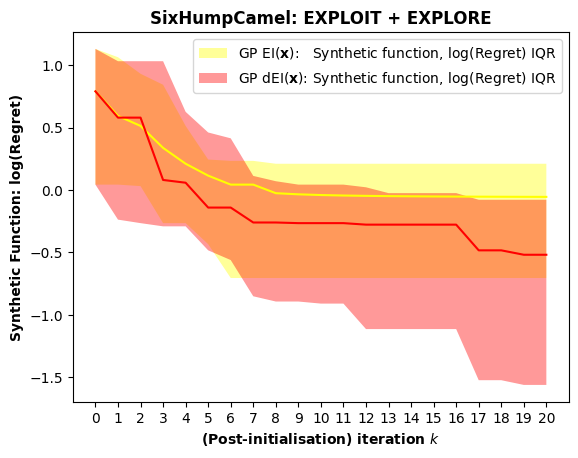

In [163]:
### Visualise!

ei_both = ': EXPLOIT + EXPLORE'
title = obj_func + ei_both

plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Red')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI($\mathbf{x}$):   Synthetic function, log(Regret) IQR')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='GP dEI($\mathbf{x}$): Synthetic function, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show()


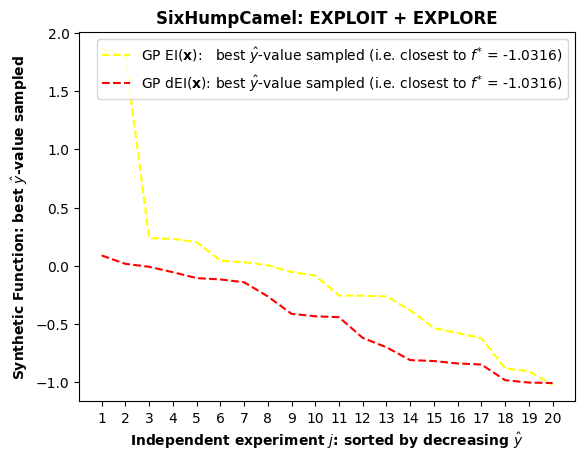

In [164]:
### Visualise!

ei_both = ': EXPLOIT + EXPLORE'
title = obj_func + ei_both

plt.figure()

plt.plot(np.sort(approx_tau)[::-1], color = 'Yellow', ls='--', label='GP EI($\mathbf{x}$):   best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = -1.0316)')
plt.plot(np.sort(exact_tau)[::-1], color = 'Red', ls='--', label='GP dEI($\mathbf{x}$): best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = -1.0316)')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$: sorted by decreasing $\it{\hat{y}}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: best $\it{\hat{y}}$-value sampled', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


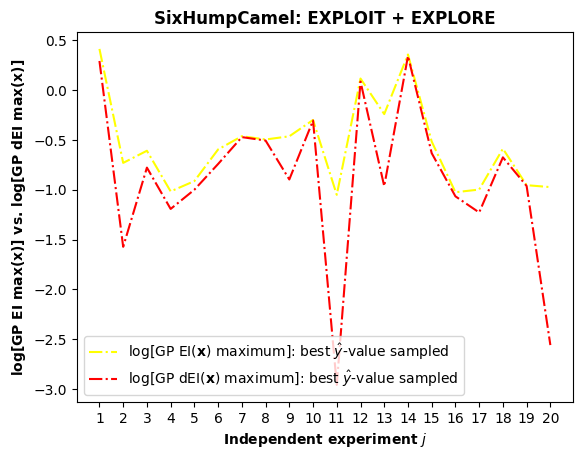

In [165]:
### Visualise!

ei_both = ': EXPLOIT + EXPLORE'
title = obj_func + ei_both

plt.figure()

plt.plot(np.log(exact_acqFuncApproxBest), color = 'Yellow', ls='-.', label='log[GP EI($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')
plt.plot(np.log(exact_acqFuncExactBest), color = 'Red', ls='-.', label='log[GP dEI($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('log[GP EI max($\mathbf{x}$)] vs. log[GP dEI max($\mathbf{x}$)]', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


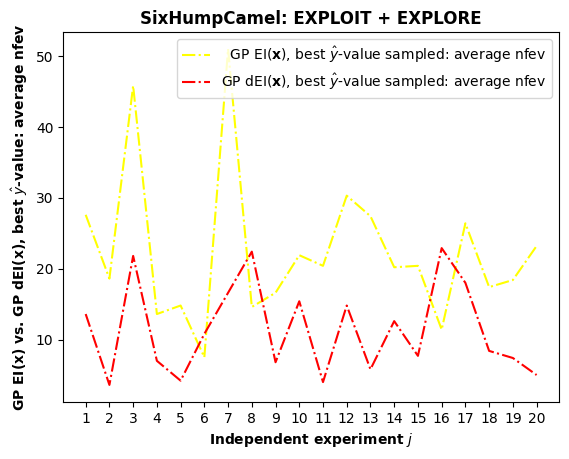

In [166]:
### Visualise!

ei_both = ': EXPLOIT + EXPLORE'
title = obj_func + ei_both

plt.figure()

plt.plot(approx_nfev_Avg, color = 'Yellow', ls='-.', label='  GP EI($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')
plt.plot(exact_nfev_Avg, color = 'Red', ls='-.', label='GP dEI($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP EI($\mathbf{x}$) vs. GP dEI($\mathbf{x}$), best $\it{\hat{y}}$-value: average nfev', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


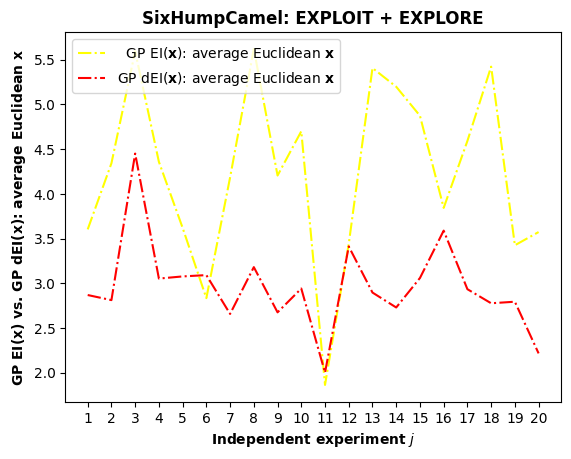

In [167]:
### Visualise!

ei_both = ': EXPLOIT + EXPLORE'
title = obj_func + ei_both

plt.figure()

plt.plot(approx_euclid_Avg, color = 'Yellow', ls='-.', label='  GP EI($\mathbf{x}$): average Euclidean $\mathbf{x}$')
plt.plot(exact_euclid_Avg, color = 'Red', ls='-.', label='GP dEI($\mathbf{x}$): average Euclidean $\mathbf{x}$')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP EI($\mathbf{x}$) vs. GP dEI($\mathbf{x}$): average Euclidean $\mathbf{x}$', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


In [168]:
np.round(-approx_4.f_best, 4), np.max(np.round(-approx_4.f_best, 4)), approx_4.best


(array([0.4725, 0.    , 0.4725, 0.1631, 0.4725, 0.    , 0.    , 0.    ,
        0.    , 0.1631, 0.4725, 0.4725, 0.4725, 0.    , 0.4725, 0.1631,
        0.    , 0.    , 0.4725, 0.4725]),
 0.4725,
 array([ 0.04340745, -0.56449043]))

In [169]:
np.round(-approx_4.f_best2, 4), np.max(np.round(-approx_4.f_best2, 4)), approx_4.best2


(array([0.3612, 0.    , 0.4319, 0.2751, 0.1631, 0.    , 0.    , 0.    ,
        0.    , 0.141 , 0.3063, 0.1533, 0.3446, 0.    , 0.3704, 0.4197,
        0.    , 0.    , 0.2834, 0.1615]),
 0.4319,
 array([-0.37550885, -0.00192909]))

In [170]:
np.round(approx_4.x_best, 4)


array([[ 0.0434, -0.5645],
       [-2.9122, -1.2587],
       [ 0.0434, -0.5645],
       [ 0.1877,  2.    ],
       [ 0.0434, -0.5645],
       [ 1.5053,  0.7924],
       [ 2.0627,  1.5641],
       [ 1.1825, -1.7503],
       [-1.8611,  0.2534],
       [ 0.1877,  2.    ],
       [ 0.0434, -0.5645],
       [ 0.0434, -0.5645],
       [ 0.0434, -0.5645],
       [-2.1159, -0.1364],
       [ 0.0434, -0.5645],
       [ 0.1877,  2.    ],
       [ 2.1594, -1.7423],
       [ 2.5632, -0.288 ],
       [ 0.0434, -0.5645],
       [ 0.0434, -0.5645]])

In [171]:
np.round(approx_4.x_best2, 4)


array([[-5.0420e-01,  1.8960e-01],
       [-2.9122e+00, -1.2587e+00],
       [-3.7550e-01, -1.9000e-03],
       [-5.6480e-01,  3.5870e-01],
       [ 1.8770e-01,  2.0000e+00],
       [ 1.5053e+00,  7.9240e-01],
       [ 2.0627e+00,  1.5641e+00],
       [ 1.1825e+00, -1.7503e+00],
       [-1.8611e+00,  2.5340e-01],
       [ 1.5640e-01,  1.7038e+00],
       [-5.4950e-01,  2.9840e-01],
       [ 2.1090e-01, -1.9191e+00],
       [-5.3010e-01,  2.1410e-01],
       [-2.1159e+00, -1.3640e-01],
       [-5.0030e-01,  1.6320e-01],
       [-4.1250e-01,  3.9700e-02],
       [ 2.1594e+00, -1.7423e+00],
       [ 2.5632e+00, -2.8800e-01],
       [ 2.8640e-01, -1.3396e+00],
       [-3.2680e-01,  8.8930e-01]])

In [172]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best)**2))


4.568799730130752

In [173]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best2)**2))

4.127454828472678